# Milestone 2 : Project proposal and initial analyses 🍻

<hr style="clear:both">
This notebook was made for the ADA course at EPFL (CS-401). 

Group : BeerADAventure46

**Authors:** \
[Agatha Hunter](https://people.epfl.ch/agatha.hunter)\
[Anne-Valérie Preto](https://people.epfl.ch/anne-valerie.preto)\
[Tristan Carruzzo](https://people.epfl.ch/tristan.carruzzo)\
[Thamin Maurer](https://people.epfl.ch/thamin.maurer)\
[Victor Dubien](https://people.epfl.ch/victor.dubien)


**Supervisor:**\
[Beatriz Borges](https://people.epfl.ch/beatriz.borges)
<hr style="clear:both">



<blockquote>

## Project proposal  📌

**Influence of the serving style on the tasting profile**:

Goal of the project: Use the textual reviews to find for each beer how it was served (either bottle, can or draft) and find how it influences the tasting profile.

Different serving styles may be adopted in different regions or for different types of beer.  The influence of the serving style could influence not only the appearance, but also the aroma, the palate or the taste.
</blockquote>

### Import libraries

In [1]:
from utils import *

pd.set_option('display.max_columns', None)

## 1. Datasets 📂

### 1.1 Import dataset

In [2]:
## Firt time imports
 
# Convert txt to parquet
#ratings = convert_txt_to_parquet(input_file='ratings.txt', export=True, file_name='ratings')
#reviews = convert_txt_to_parquet(input_file='reviews.txt', export=True, file_name='reviews')

<div class="alert alert-block alert-danger">
<b>Danger:</b> 
Change function to read directly from zip file!
</div>

In [3]:
## Files already converted, so we can load them directly

#reviews = pq.read_table(dataset_path + 'reviews.csv').to_pandas()
reviews = pd.read_csv(dataset_path + 'reviews.csv')
beers = pd.read_csv(dataset_path + 'beers.csv')
breweries = pd.read_csv(dataset_path + 'breweries.csv')
users = pd.read_csv(dataset_path + 'users.csv')

### 1.2 Initial datasets analysis 🔎

#### 1.2.1 Beers dataset 🍺

In [4]:
display(beers.sample(3))
print('Shape of beers : ', beers.shape)

,beer_id,beer_name,brewery_id,brewery_name,style,nbr_ratings,nbr_reviews,avg,ba_score,bros_score,abv,avg_computed,zscore,nbr_matched_valid_ratings,avg_matched_valid_ratings
158376,114341,Roundabout Stout,32390,Roundabout Brewery,American Stout,2,0,3.75,NaN,NaN,6.5,3.75,-0.259806,0,NaN
270006,43778,Blue Heron Kolsch,10799,Ham's Restaurant & Brewhouse,Kölsch,1,1,3.71,NaN,NaN,NaN,3.71,NaN,0,NaN
131134,157748,Nature's Nectar,267,Odell Brewing Company,Saison / Farmhouse Ale,1,0,3.89,NaN,NaN,7.2,3.89,NaN,0,NaN


Shape of beers :  (280823, 15)


In [5]:
# print the number of beers id and beer name
print('Number of different beers id:', len(beers.beer_id.unique()))
print('Number of different beers name:', len(beers.beer_name.unique()))

Number of different beers id: 280823
Number of different beers name: 236209


<blockquote>

**Initial comments about the dataset**

-Some beers have the same name! In order to avoid confusion, we will drop the column beer_name (and brewery_name) from the dataset.

-As we will not use the RateBeer dataset, we can also drop the column nbr_matched_valid_ratings and avg_matched_valid_ratings.  

-The column bros_score only reflect the ratings from the two creators of the website, so we can also drop it.  

-ba_score represents the percentage (rounded to the tenth for depth) of raters who gave the beer a 3.75 or higher as long as the beers as at least 10 ratings.

</blockquote>

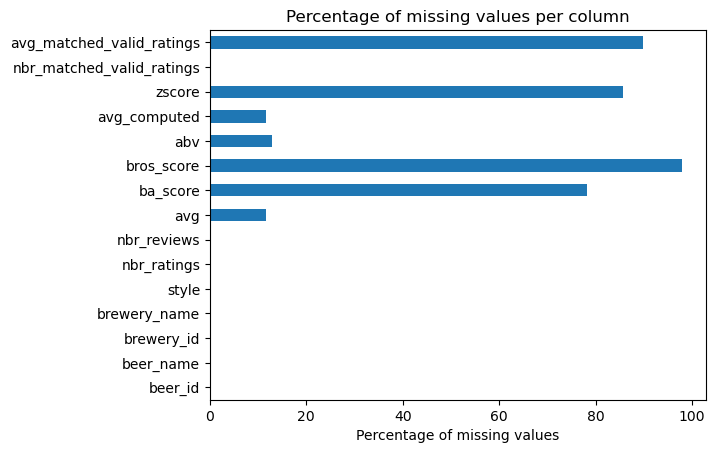

avg                      : 32829 missing values (11.69%)
ba_score                 : 219623 missing values (78.21%)
bros_score               : 275121 missing values (97.97%)
abv                      : 36024 missing values (12.83%)
avg_computed             : 32841 missing values (11.69%)
zscore                   : 240538 missing values (85.65%)
avg_matched_valid_ratings: 252551 missing values (89.93%)


In [6]:
show_missing(beers)

<blockquote>

**More comments about the dataset**

-We see that more than 80% of the beers do not have a z-score value. Since this value takes into account reviews from both websites and is vastly missing, we can drop the column alongside avg_computed. We might compute them manually later if needed.

-80% of the beers have no ba_score value, so we can also drop it and compute it later if needed.

-The other columns with NaN such as avg_matched_valid_ratings, avg_computed or bros_score are not useful in our analysis since we only look at the BeerAdvocate reviews.

-The column abv, which represents the alcohol percentage in a beer, is missing for approximately 12%.

</blockquote>

In [7]:
beers_filtered = beers.drop(columns=['beer_name', 
                            'brewery_name',
                            'bros_score',
                            'ba_score',
                            'nbr_matched_valid_ratings',
                            'avg_matched_valid_ratings',
                            'zscore',
                            'avg_computed']).copy(deep=True)

beers_filtered.rename(columns={'nbr_ratings': 'beer_nbr_ratings',
                               'nbr_reviews': 'beer_nbr_reviews'}, inplace=True)

In [8]:
beers_filtered.sample(3)

,beer_id,brewery_id,style,beer_nbr_ratings,beer_nbr_reviews,avg,abv
32989,38827,14338,Belgian Pale Ale,2,2,3.40,4.7
66351,208260,7730,American Pale Wheat Ale,1,0,3.93,4.5
8606,62749,4888,English Porter,2,1,3.73,3.8


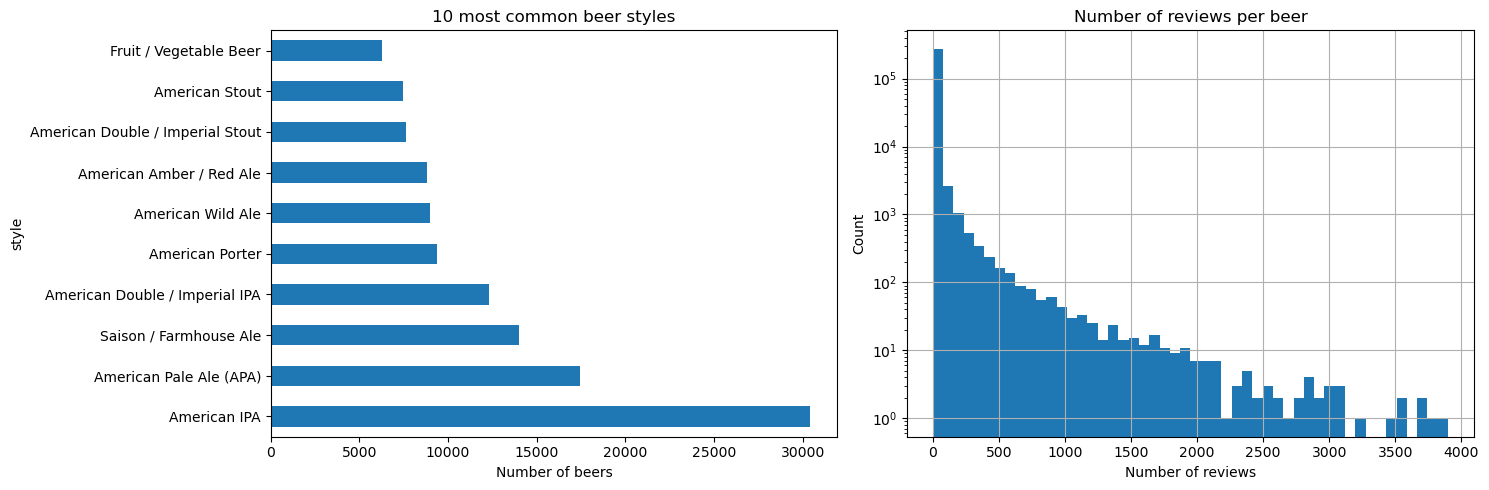

In [9]:
# Representation of the beers dataset
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
beers_filtered['style'].value_counts(normalize=False).head(10).plot(kind='barh', title='10 most common beer styles')
plt.xlabel('Number of beers')
plt.subplot(1, 2, 2)
beers_filtered['beer_nbr_reviews'].hist(bins=50,log=True)
plt.title('Number of reviews per beer')
plt.ylabel('Count')
plt.xlabel('Number of reviews')
plt.tight_layout()
plt.show()

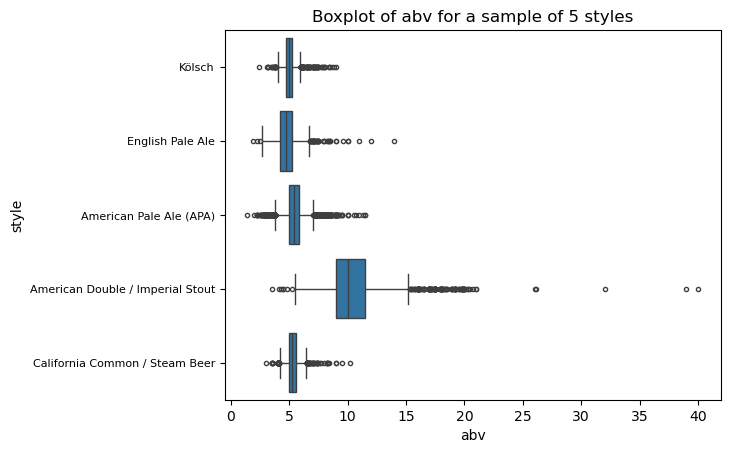

In [10]:
# boxplot of abv for sample of beers 
plt.figure()
sample_styles = beers_filtered['style'].sample(5)  # Select a sample of 5 beer styles
sns.boxplot(y='style', x='abv', data=beers_filtered[beers_filtered['style'].isin(sample_styles)], fliersize=3)
plt.yticks(fontsize=8)
plt.title('Boxplot of abv for a sample of 5 styles')
plt.show()

In [11]:
# group the beers by style and compute the median of abv for each style
median_abv_by_style = beers_filtered.groupby('style')['abv'].median()
# display(median_abv_by_style.sample(3))

# fill the missing abv values with the median of abv for the style of each beer
beers_filtered['abv'] = beers_filtered.apply(lambda x: median_abv_by_style[x['style']] if pd.isna(x['abv']) else x['abv'], axis=1)

In [12]:
beers_filtered.describe()

,beer_id,brewery_id,beer_nbr_ratings,beer_nbr_reviews,avg,abv
count,280823.000000,280823.000000,280823.000000,280823.000000,247994.000000,280823.000000
mean,148556.817141,21335.895860,29.887267,9.221417,3.721034,6.434481
std,84307.593397,15385.715656,231.010063,68.866445,0.476003,1.984850
min,3.000000,1.000000,0.000000,0.000000,0.000000,0.010000
25%,76513.500000,3835.000000,1.000000,0.000000,3.500000,5.000000
50%,148867.000000,24075.000000,2.000000,1.000000,3.780000,6.000000
75%,221817.500000,33960.000000,8.000000,2.000000,4.010000,7.300000
max,293296.000000,49817.000000,16509.000000,3899.000000,5.000000,67.500000


<blockquote>

We are left with a dataset containing 280823 beers. We are only missing some values for avg as some beers do not have any ratings/reviews. They will be removed later when merging with the reviews dataset anyway.

</blockquote>

#### 1.2.2 Breweries dataset 🏭

In [13]:
display(breweries.sample(3))
print('Shape of breweries : ', breweries.shape)

,id,location,name,nbr_beers
2699,4973,Japan,Kamakura Beer Brewing Company,8
6753,41283,South Africa,Striped Horse,2
5868,45329,Argentina,Cerveceria Porteña,4


Shape of breweries :  (16758, 4)


In [14]:
# show the missing values
show_missing(breweries)

There are no missing values in this dataset.


<blockquote>

This dataset has no missing values, we will simply rename the columns and drop the brewery name.

</blockquote>

In [15]:
breweries_filtered = breweries.drop(columns=['name']).copy(deep=True)

breweries_filtered.rename(columns={'id':'brewery_id',
                                   'location':'brewery_location',
                                   'nbr_beers':'brewery_nbr_beers'}, inplace=True)

In [16]:
display(breweries_filtered.sample(3))
print('Shape of breweries filtered: ', breweries_filtered.shape)

,brewery_id,brewery_location,brewery_nbr_beers
11158,31478,"United States, Mississippi",13
11510,27947,"United States, Alabama",36
14205,36261,"United States, South Carolina",13


Shape of breweries filtered:  (16758, 3)


In [17]:
# Some breweries have weird location values, they contain google maps links. All the breweries with a weird location value are in the US.
print('Number of breweries with a weird location value:', len(breweries_filtered[breweries_filtered['brewery_location'].str.contains('<', na=False)]))

# for loc in breweries_filtered[breweries_filtered['brewery_location'].str.contains('<', na=False)]['brewery_location'].unique():
#     print(loc) # print the strange values

Number of breweries with a weird location value: 35


In [18]:
# manually adding the location for those 35 breweries

#obtain the brewery_id of the 35 breweries
strange_id = breweries_filtered[breweries_filtered['brewery_location'].str.contains('<', na=False)]['brewery_id'].unique()

# create a dic with the brewery_id as key and unknwon as value
dic = {}
for i in strange_id:
    dic[i] = 'unknown'
    
# function that takes as input the brewery_id and a location and change the location of the brewery with the given id in the dictionary dic 
def change_location(brewery_id, us_state):
    location = 'United States, ' + us_state
    dic[brewery_id] = location

In [19]:
# take the first element of dic that has value unknown and print its location
for key, value in dic.items():
    if value == 'unknown':
        print('Brewery id:', key)
        print('Strange location:',breweries_filtered[breweries_filtered['brewery_id'] == key]['brewery_location'].values[0])        
        break

Brewery id: 2434
Strange location: United States</a> | <a href="http://maps.google.com/maps?oi=map&q=%2C+US" target="_blank">map</a><br><a href="http://bluecorncafe.com" target="_blank">bluecorncafe.com


In [20]:
#Changing the location in dic

change_location(brewery_id=2434,us_state='New Mexico')
change_location(brewery_id=2730,us_state='Wisconsin')
change_location(brewery_id=1551,us_state='California')
change_location(brewery_id=1552,us_state='Michigan')
change_location(brewery_id=2710,us_state='California')
change_location(brewery_id=3681,us_state='Ohio')
change_location(brewery_id=2413,us_state='California')
change_location(brewery_id=1793,us_state='Virginia')
change_location(brewery_id=6045,us_state='New Jersey')
change_location(brewery_id=2776,us_state='New York')
change_location(brewery_id=1751,us_state='Texas')
change_location(brewery_id=1554,us_state='Georgia')
change_location(brewery_id=1961,us_state='Maine')
change_location(brewery_id=4927,us_state='South Carolina')
change_location(brewery_id=23973,us_state='Maine')
change_location(brewery_id=2512,us_state='California')
change_location(brewery_id=6416,us_state='New Jersey')
change_location(brewery_id=2104,us_state='Oregon')
change_location(brewery_id=3079,us_state='Washington')
change_location(brewery_id=2410,us_state='Michigan')
change_location(brewery_id=1931,us_state='Ohio')
change_location(brewery_id=1553,us_state='Maine')
change_location(brewery_id=1550,us_state='Colorado')
change_location(brewery_id=32764,us_state='Illinois')
change_location(brewery_id=8451,us_state='Wyoming')
change_location(brewery_id=5114,us_state='California')
change_location(brewery_id=1802,us_state='North Carolina')
change_location(brewery_id=1819,us_state='Minnesota')
change_location(brewery_id=200,us_state='California')
change_location(brewery_id=918,us_state='Florida')
change_location(brewery_id=4343,us_state='California')
change_location(brewery_id=9765,us_state='New York')
change_location(brewery_id=1927,us_state='Colorado')
change_location(brewery_id=28908,us_state='Utah')
change_location(brewery_id=70,us_state='Oregon')
change_location(brewery_id=1567,us_state='Hawaii')

In [21]:
# change the location of the breweries in the breweries_filtered dataframe
for key, value in dic.items():
    breweries_filtered.loc[breweries_filtered['brewery_id'] == key, 'brewery_location'] = value

In [22]:
# how many different locations are there that contain United States
print('Number of different locations that contain United States:', len(breweries_filtered[breweries_filtered['brewery_location'].str.contains('United States')]['brewery_location'].unique()))

Number of different locations that contain United States: 50


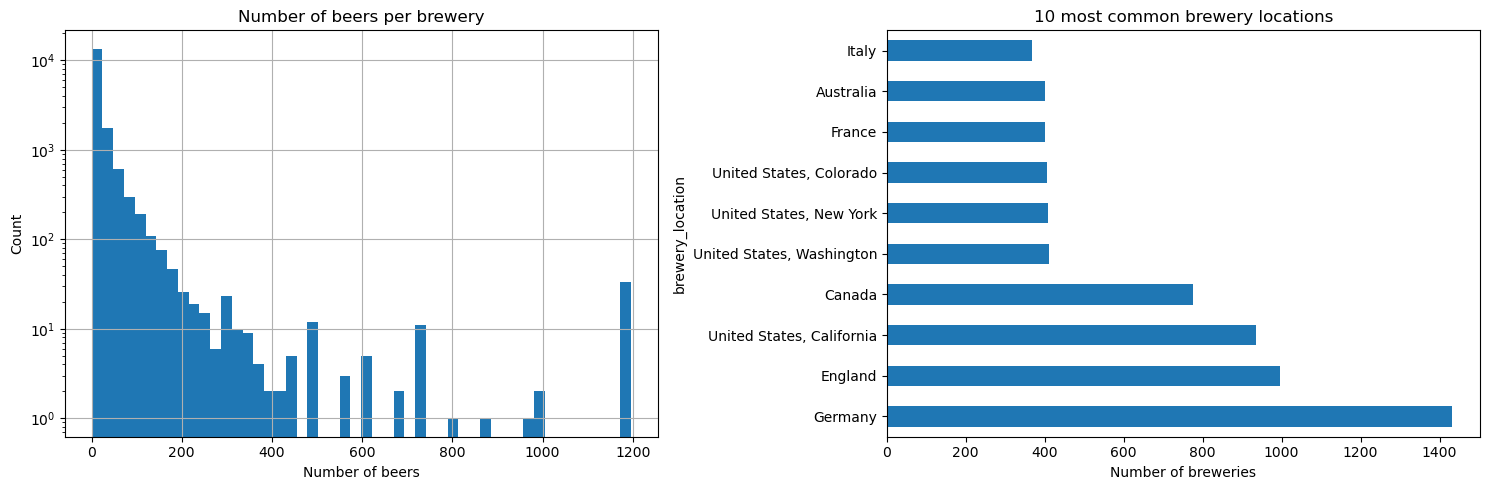

In [23]:
# Representation of beers per brewery and most common brewery locations
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
breweries_filtered['brewery_nbr_beers'].hist(bins=50, log=True)
plt.title('Number of beers per brewery')
plt.ylabel('Count')
plt.xlabel('Number of beers')
plt.subplot(1, 2, 2)
breweries_filtered['brewery_location'].value_counts(normalize=False).head(10).plot(kind='barh', title='10 most common brewery locations')
plt.xlabel('Number of breweries')
plt.tight_layout()
plt.show()

#### 1.2.3 Users dataset 👤

In [24]:
display(users.sample(3))
print('Shape of users : ', users.shape)

,nbr_ratings,nbr_reviews,user_id,user_name,joined,location
46497,22,0,brennenw56.864716,brennenw56,1.410948e+09,"United States, Illinois"
1602,2138,3,hilgart1.570026,hilgart1,1.298200e+09,"United States, Illinois"
38704,3,0,japanmeetsdenmark.1002788,japanmeetsdenmark,1.434881e+09,Canada


Shape of users :  (153704, 6)


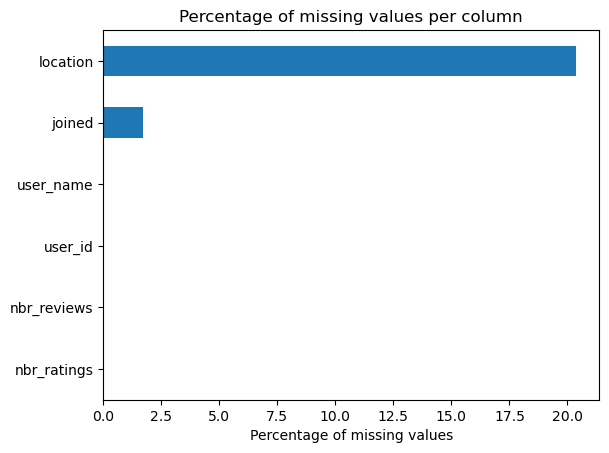

user_name                :     1 missing values (0.00%)
joined                   :  2652 missing values (1.73%)
location                 : 31279 missing values (20.35%)


In [25]:
show_missing(users)

<blockquote>

We are only missing information about when the user joined the website and locations. (and 1 username, which we drop anyway)

</blockquote>

In [26]:
users_filtered = users.drop(columns=['user_name']).copy(deep=True)

users_filtered.rename(columns={'nbr_ratings':'user_nbr_ratings',
                               'nbr_reviews':'user_nbr_reviews',
                               'joined':'user_joined',
                               'location':'user_location'}, inplace=True)

display(users_filtered.sample(3))
print('Shape of users filtered: ', users_filtered.shape)

,user_nbr_ratings,user_nbr_reviews,user_id,user_joined,user_location
35169,280,6,adamelb.727726,1.365502e+09,"United States, New York"
5046,12,0,kirkbuchanan.944641,1.423912e+09,"United States, Texas"
126103,2,1,gingerjesus504.1133126,1.460628e+09,"United States, Louisiana"


Shape of users filtered:  (153704, 5)


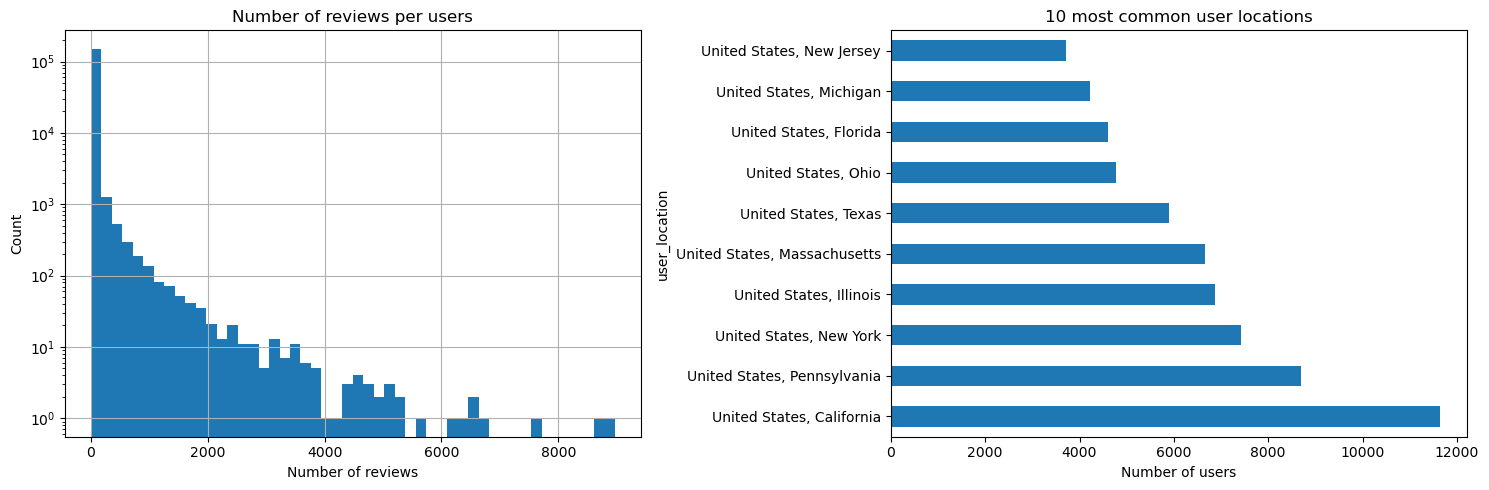

In [27]:
# Representation of reviews per user and most common user locations
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
users_filtered['user_nbr_reviews'].hist(bins=50, log=True)
plt.title('Number of reviews per users')
plt.ylabel('Count')
plt.xlabel('Number of reviews')
plt.subplot(1, 2, 2)
users_filtered['user_location'].value_counts(normalize=False).head(10).plot(kind='barh', title='10 most common user locations')
plt.xlabel('Number of users')
plt.tight_layout()
plt.show()

<blockquote>

We observe that many users have no reviews at all, they will be removed from the dataset when merging. Also, the 10 most common user location are all in the US.

</blockquote>

#### 1.2.4 Reviews dataset 📝

In [28]:
display(reviews.sample(3))
print('Shape of reviews : ', reviews.shape)

,beer_name,beer_id,brewery_name,brewery_id,style,abv,date,user_name,user_id,appearance,aroma,palate,taste,overall,rating,text
734470,Highway 128 Session Series: Blood Orange Gose,132073,Anderson Valley Brewing Company,193,Gose,4.2,1443520800,Extol,extol.752626,4.25,4.75,4.5,4.75,4.25,4.60,Appearance - dark gold in color. Smell - holy ...
1435404,Stateside Saison,57210,Stillwater Artisanal Ales,22150,Saison / Farmhouse Ale,6.8,1316685600,vandemonian,vandemonian.497441,4.50,4.00,4.0,4.50,4.50,4.33,Stillwater Stateside Saison is a delicious sai...
1265159,Sleeping Elephant,78170,Pateros Creek Brewing Co.,24671,Winter Warmer,6.9,1328439600,ScorpyX,scorpyx.408278,4.00,5.00,4.0,4.00,4.50,4.34,A: Pours a dark copper color. The head soon de...


Shape of reviews :  (2589586, 16)


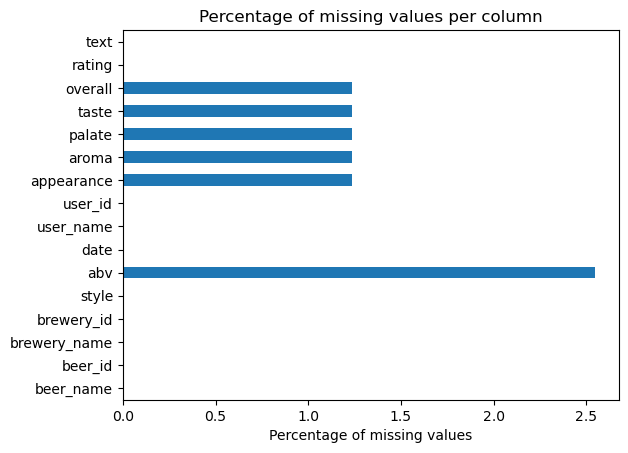

abv                      : 65983 missing values (2.55%)
user_name                :     3 missing values (0.00%)
appearance               : 32009 missing values (1.24%)
aroma                    : 32009 missing values (1.24%)
palate                   : 32009 missing values (1.24%)
taste                    : 32009 missing values (1.24%)
overall                  : 32009 missing values (1.24%)
text                     :     2 missing values (0.00%)


In [29]:
show_missing(reviews)

In [30]:
# making sure that all the missing values of the rating aspects are in the same rows

# print the number of rows that contains a NaN value for each column ['overall', 'taste', 'palate', 'aroma', 'appearance']
print('Number of rows with NaN values for each column :')
for col in ['overall', 'taste', 'palate', 'aroma', 'appearance']:
    print(col, ':', len(reviews[reviews[col].isna()]))
    
print()
# print the number of rows that contains a NaN value for all the rating aspects
missing_values = reviews[['overall', 'taste', 'palate', 'aroma', 'appearance']].isna()
missing_values['all_missing'] = missing_values.all(axis=1)
print(missing_values['all_missing'].value_counts())

Number of rows with NaN values for each column :
overall : 32009
taste : 32009
palate : 32009
aroma : 32009
appearance : 32009

all_missing
False    2557577
True       32009
Name: count, dtype: int64


<blockquote>

All the missing values are in the same rows, and they represent less than 1.5% of the dataset. We can drop them.

</blockquote>

In [31]:
# remove the columns that are not useful for our analysis
reviews_filtered = reviews.drop(columns=['user_name', 'beer_name', 'brewery_name']).copy(deep=True)

# remove the column abv because we have the information in the beers dataframe
reviews_filtered.drop(columns=['abv'], inplace=True)

#remove rows in reviews_filtered that have all_missing True in missing_values
reviews_filtered = reviews_filtered[~missing_values['all_missing']].copy(deep=True)

#remove the two reviews that have no text
reviews_filtered = reviews_filtered[~reviews_filtered['text'].isna()].copy(deep=True)

display(reviews_filtered.sample(3))
print('Shape of reviews_filtered : ', reviews_filtered.shape)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text
2424798,5357,47,Gueuze,1372068000,vkv822.398670,3.75,4.25,4.0,4.25,4.25,4.20,"12.7oz C&amp;C : tulip2008 vintage.Clear, deep..."
990932,71758,35,Rauchbier,1315908000,hoagie1973.191162,4.00,3.00,3.0,2.50,3.00,2.86,Deep amber brown with a decent enough head.Sme...
2567202,80359,22994,American IPA,1336384800,stevemi.673809,3.00,3.00,3.0,4.50,4.00,3.80,A - Light yellow. Not much head to it (but tak...


Shape of reviews_filtered :  (2557575, 12)


In [32]:
show_missing(reviews_filtered)

There are no missing values in this dataset.


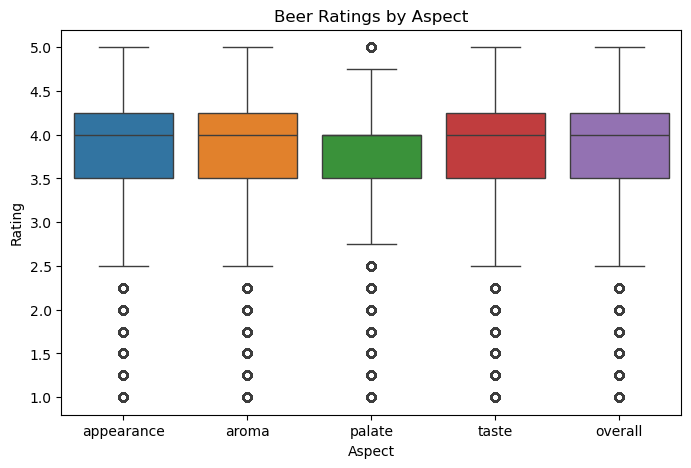

In [33]:
# boxplot for each rating column, appearance, aroma, palate, taste and overall

plt.figure(figsize=(8, 5))
sns.boxplot(data=reviews_filtered[['appearance', 'aroma', 'palate', 'taste', 'overall']])
plt.title('Beer Ratings by Aspect')
plt.xlabel('Aspect')
plt.ylabel('Rating')
plt.show()

### 1.3 Merge datasets 🔗

In [34]:
# Merge reviews with users and beers and breweries
df_merged = reviews_filtered.merge(beers_filtered, how='left', on=['beer_id', 'brewery_id', 'style'])
df_merged = df_merged.merge(users_filtered, how='left', on='user_id')
df_merged = df_merged.merge(breweries_filtered, how='left', on='brewery_id')

display(df_merged.sample(1))
print('Shape of df_merged : ', df_merged.shape)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers
1608527,217906,583,Saison / Farmhouse Ale,1457521200,memphisjoe14.858861,4.5,4.25,4.5,4.75,4.75,4.59,"Look - Yellow with white head that stays, soli...",11,6,4.08,6.4,37,18,1.409998e+09,"United States, Illinois","United States, Missouri",237


Shape of df_merged :  (2557575, 22)


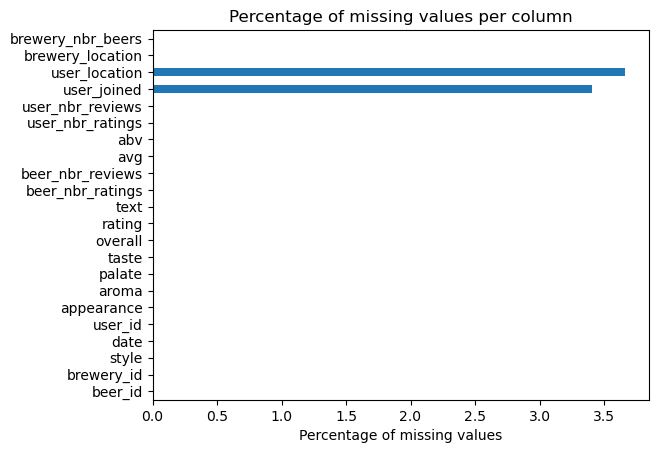

user_joined              : 87150 missing values (3.41%)
user_location            : 93668 missing values (3.66%)


In [35]:
show_missing(df_merged)

In [36]:
# We can replace missing user_joined values with the date of the first review of the user
df_merged['first_review'] = df_merged.groupby('user_id')['date'].transform('min')
df_merged['user_joined'] = df_merged['user_joined'].fillna(df_merged['first_review'])
df_merged.drop(columns=['first_review'], inplace=True)

> We have an almost complete dataset. Only information about the location of users is missing for 3.66% reviews.

In [38]:
# Save to csv
#df_merged.to_csv(dataset_path + 'BeerAdvocateMerged.csv', index=False)
df_merged.to_parquet(dataset_path + 'BeerAdvocateMerged.parquet', index=False)

## 2. Data enrichment 🍺

In [39]:
# load csv from step 1
df = pq.read_table(dataset_path + 'BeerAdvocateMerged.parquet').to_pandas()
#df = pd.read_csv(dataset_path + 'BeerAdvocateMerged.csv')

In [40]:
# for some fine analysis, we will compute the avg appearance, aroma, palate, taste and overall per beer
df['beer_id_avg_appearance'] = df.groupby('beer_id')['appearance'].transform('mean')
df['beer_id_avg_aroma'] = df.groupby('beer_id')['aroma'].transform('mean')
df['beer_id_avg_palate'] = df.groupby('beer_id')['palate'].transform('mean')
df['beer_id_avg_taste'] = df.groupby('beer_id')['taste'].transform('mean')
df['beer_id_avg_overall'] = df.groupby('beer_id')['overall'].transform('mean')

df['beer_id_std'] = df.groupby('beer_id')['overall'].transform('std')
df['beer_id_std_appearance'] = df.groupby('beer_id')['appearance'].transform('std')
df['beer_id_std_aroma'] = df.groupby('beer_id')['aroma'].transform('std')
df['beer_id_std_palate'] = df.groupby('beer_id')['palate'].transform('std')
df['beer_id_std_taste'] = df.groupby('beer_id')['taste'].transform('std')
df['beer_id_std_overall'] = df.groupby('beer_id')['overall'].transform('std')

df_initial = df.copy(deep=True)


In [41]:
display(df.sample(3))
print('Shape of df : ', df.shape)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,beer_id_avg_appearance,beer_id_avg_aroma,beer_id_avg_palate,beer_id_avg_taste,beer_id_avg_overall,beer_id_std,beer_id_std_appearance,beer_id_std_aroma,beer_id_std_palate,beer_id_std_taste,beer_id_std_overall
134519,26072,22,Belgian Dark Ale,1232794800,surfer4life.230033,4.00,4.5,3.5,3.00,3.0,3.47,Poured into a tulip from a 12oz bottle. A - Da...,899,646,3.69,6.2,94,94,1.214215e+09,"United States, California",Canada,58,3.862016,3.659302,3.584109,3.654264,3.737984,0.582775,0.455248,0.511049,0.549208,0.548007,0.582775
478628,31266,13837,American Stout,1411120800,brentk56.6284,3.75,4.0,4.0,4.25,4.0,4.09,Appearance: The pitch black liquid arrives wi...,216,51,4.09,7.0,6306,6306,1.084442e+09,"United States, North Carolina","United States, Wisconsin",62,4.065000,3.985000,4.150000,4.165000,4.110000,0.407706,0.349234,0.423813,0.422577,0.472752,0.407706
1341391,17060,158,American Double / Imperial IPA,1158141600,tattooedtolley.60452,4.50,4.5,4.0,4.50,4.5,4.45,Appearance: Pours a copper/orange color with a...,4168,1583,4.13,10.0,164,164,1.137582e+09,"United States, Virginia","United States, Colorado",148,4.179548,4.123410,4.126908,4.182888,4.063136,0.519616,0.447256,0.470862,0.477323,0.514382,0.519616


Shape of df :  (2557575, 33)


### 2.1 Serving style 🍾🥤🚰

#### 2.1.1 naive approach

>Since our goal is to look at the influence of the serving style, we need to know how each beer was served.   
A first idea was to use a naive approach. We only look at whether a word specific to as service style has been used. 

In [42]:
def serving_type_naive(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create a new column serving_type_naive that contains the serving type of the beer using the naive approach.

    Parameters:
    - df (pd.DataFrame): The input dataframe.

    Returns:
    - pd.DataFrame: The dataframe with the added 'serving_type_naive' column.
    """
    # Create 3 different columns according to the text review, "bottle", "can", "draft"
    bottle = {'bottle', 'bottled', 'bottles', 'bomber'}
    can = {'can', 'canned', 'cans', }
    draft = {'draft', 'draught', 'tap', 'taps', 'cask', 'growler', 'keg'}
    
    # Create different columns if review text contains the word
    df['bottle'] = df['text'].astype(str).apply(lambda x: any(ele in x.lower() for ele in bottle))
    df['can'] = df['text'].astype(str).apply(lambda x: any(ele in x.lower() for ele in can))
    df['draft'] = df['text'].astype(str).apply(lambda x: any(ele in x.lower() for ele in draft))
    
    # Initialize the serving_type_naive column to 'not_set' with dtype str
    df['serving_type_naive'] = 'not_set'
    df['serving_type_naive'] = df['serving_type_naive'].astype(str)
    
    # if there are more than one true or no true, set the value to 'unknown'
    df.loc[df[['bottle', 'can', 'draft']].sum(axis=1) != 1, 'serving_type_naive'] = 'unknown'

    # drop the columns bottle, can, and draft
    df.drop(['bottle', 'can', 'draft'], axis=1, inplace=True)
    
    return df

#### 2.1.2 Similarity 🍾🥤🚰

> Compute the similarity between the reviews and a list of words specific to each serving style. The list is more exhaustive in this method, using words such as aluminium or cork for can and bottle respectively. Select the serving style with the highest similarity.

In [43]:
def serving_type_sim(df: pd.DataFrame, word_bottle: str = 'data/bottle.txt', word_can: str = 'data/can.txt', word_draft: str = 'data/draft.txt', threshold: float = 0.05) -> pd.DataFrame:
    """
    Compute the cosine similarity between the review text and the list of words for each serving type. 
    Select the serving type with the highest similarity score.

    Parameters:
    - df (pd.DataFrame): The input dataframe.
    - word_bottle (str): Path to the text file containing words related to 'bottle' serving type.
    - word_can (str): Path to the text file containing words related to 'can' serving type.
    - word_draft (str): Path to the text file containing words related to 'draft' serving type.
    - threshold (float): The threshold for considering a serving type based on cosine similarity.

    Returns:
    - pd.DataFrame: The dataframe with the added 'serving_type_sim' column.
    """
    # Read the list of words from the text file
    with open(word_can, 'r') as file:
        word_can = file.read().splitlines()

    with open(word_bottle, 'r') as file:
        word_bottle = file.read().splitlines()

    with open(word_draft, 'r') as file:
        word_draft = file.read().splitlines()

    # Create a TF-IDF vectorizer
    vectorizer = TfidfVectorizer(stop_words='english')

    # Transform the review and words list using TF-IDF
    tfidf_matrix = vectorizer.fit_transform(df['text'].astype(str))

    can_vector = vectorizer.transform([" ".join(word_can)])
    bottle_vector = vectorizer.transform([" ".join(word_bottle)])
    draft_vector = vectorizer.transform([" ".join(word_draft)])

    # Calculate the cosine similarity
    cosine_sim_can = cosine_similarity(tfidf_matrix, can_vector)
    cosine_sim_bottle = cosine_similarity(tfidf_matrix, bottle_vector)
    cosine_sim_draft = cosine_similarity(tfidf_matrix, draft_vector)

    # Get the maximum similarity score and corresponding serving type
    max_sim = np.maximum.reduce([cosine_sim_bottle, cosine_sim_can, cosine_sim_draft])
    serving_type = np.where(max_sim >= threshold, np.array(['bottle', 'can', 'draft'])[np.argmax([cosine_sim_bottle, cosine_sim_can, cosine_sim_draft], axis=0)], 'unknown')

    # Add the serving_type_sim column to the dataframe
    df['serving_type_sim'] = serving_type

    return df

#### 2.1.3 Rule-based approach 🍾🥤🚰

> Homemade algorithm used to find the serving type using a rule-based approach.

In [44]:
nlp = spacy.load("en_core_web_sm")
from spacy.tokens import Doc

def differentiate_can(doc: Doc) -> List[str]:
    """
    Differentiate between the noun and verb form of the word "can" in the review text.

    Parameters:
    - doc (spacy.tokens.Doc): The input SpaCy Doc object representing the review text.

    Returns:
    - List[str]: A list indicating whether each occurrence of "can" is used as a noun or a verb.
    """
    verbes_nom = []
    for token in doc:
        if token.text.lower() == "can" and any(t.dep_ == "aux" for t in token.head.children):
            verbes_nom.append("verb")
        elif token.text.lower() == "can":
            verbes_nom.append("noun")

    return verbes_nom

def remove_conditional(doc: Doc) -> Doc:
    """
    Remove parts of the review text that are in the conditional form.

    Parameters:
    - doc (spacy.tokens.Doc): The input SpaCy Doc object representing the review text.

    Returns:
    - spacy.tokens.Doc: The modified SpaCy Doc object with conditional parts removed.
    """
    modified_tokens = []
    remove_sentence = False

    for sent in doc.sents:
        for token in sent:
            if remove_sentence:
                continue
            if token.text.lower() in {"would", "could", "'d", "will"}:
                subtree = [t.text for t in token.subtree]
                modified_tokens.extend(subtree[:-1])
                remove_sentence = True
            else:
                modified_tokens.append(token.text)

    modified_text = " ".join(modified_tokens)

    return nlp(modified_text)

def extract_serving_style(review: str) -> str:
    """
    Return the serving style of the beer using the rule-based approach.

    Parameters:
    - review (str): The input text of the beer review.

    Returns:
    - str: The serving style of the beer.
    """
    bottle = {'bottle', 'bottled', 'bottles', 'bomber'}
    can = {'can', 'canned', 'cans'}
    draft = {'draft', 'draught', 'tap', 'taps', 'cask', 'growler', 'on-tap', 'keg'}

    modified_doc = remove_conditional(nlp(review))
    #modified_doc = nlp(review)

    serving_styles = set()

    if any(word in modified_doc.text.lower() for word in bottle):
        serving_styles.add("bottle")
    if any(word in modified_doc.text.lower() for word in can) and "noun" in differentiate_can(modified_doc):
        serving_styles.add("can")
    if any(word in modified_doc.text.lower() for word in draft):
        serving_styles.add("draft")

    serving_style = serving_styles.pop() if len(serving_styles) == 1 else 'unknown'

    return serving_style

def process_row(row: pd.Series) -> str:
    """
    Process a row of a DataFrame, extracting the serving style of the beer from the 'text' column.

    Parameters:
    - row (pd.Series): A row of a DataFrame containing a 'text' column.

    Returns:
    - str: The serving style of the beer.
    """
    serving_style = extract_serving_style(row.text)
    return serving_style

def serving_type_rulebased(df: pd.DataFrame) -> pd.DataFrame:
    """
    Apply the rule-based serving type extraction function to each row of the DataFrame in parallel.

    Parameters:
    - df (pd.DataFrame): The input dataframe.

    Returns:
    - pd.DataFrame: The dataframe with the added 'serving_type_rulebased' column.
    """
    # Number of threads to run in parallel (adjust based on your system)
    num_threads = 6
    
    with ThreadPoolExecutor(max_workers=num_threads) as executor:
        # Apply the function in parallel to each row of the DataFrame
        results = list(tqdm(executor.map(process_row, df.itertuples(index=False)), total=len(df)))

    # Add the results to the DataFrame
    df['serving_type_rulebased'] = results
    
    return df

In [45]:
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize

#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')


def differentiate_can_tense(doc: Doc) -> List[str]:
    """
    Differentiate between the noun and verb form of the word "can" in the review text.

    Parameters:
    - doc (spacy.tokens.Doc): The input SpaCy Doc object representing the review text.

    Returns:
    - List[str]: A list indicating whether each occurrence of "can" is used as a noun or a verb.
    """
    verbes_nom = []
    for token in doc:
        if token.text.lower() == "can" and any(t.dep_ == "aux" for t in token.head.children):
            verbes_nom.append("verb")
        elif token.text.lower() == "can":
            verbes_nom.append("noun")

    return verbes_nom            


def detect_tense_before_containers(text):

    bottle = {'bottle', 'bottled', 'bottles', 'bomber'}
    can = {'can', 'canned', 'cans'}
    draft = {'draft', 'draught', 'tap', 'taps', 'cask', 'on-tap','growler', 'keg'}
    modified_doc = nlp(text)
    
    sentences = nltk.sent_tokenize(text)

    container = []
    poss =[]

    # Process each sentence
    for sentence in sentences:
        # Tokenize the sentence into words
        words = word_tokenize(sentence)
        # Perform part-of-speech tagging
        pos_tags = pos_tag(words)
        # Create a spaCy doc for the sentence
        doc = nlp(" ".join(words))

        # Identify the tense based on the POS tags
        for i in range(len(pos_tags)):
            word, pos = pos_tags[i]

            if word.lower() in bottle:
                word = 'bottle'
                pos = 'NN'
            elif word.lower() in can and "noun" in differentiate_can_tense(modified_doc):
                pos = 'NN'
                #print(pos)
                word = 'can'
            elif word.lower() in draft:
                word = 'draft'

            # Check for beer container words
            if word.lower() in ['bottle', 'can', 'draft']:
    
                # A bool to check if there is a verb before the word
                #verb_bool = False

                # Check that the word is not a verb
                if pos not in ['VBD', 'VBN', 'VBG', 'VBZ', 'VBP', 'MD']:
                    verb_bool = False
                        # Find the tense of the verb just before the container word
                    for j in range(i - 1, -1, -1):
                        prev_word, prev_pos = pos_tags[j]
    
                            # Don't want the serving type if it is in the future
                        if prev_pos in ['MD']:
                            verb_bool = True
                                #print(prev_pos)
                            #break
    
                        if prev_pos in ['VBG', 'VBZ', 'VBP']:
                            poss.append(prev_pos)
                            container.append(word)
                            verb_bool = False
                            #break
                            
                            
                                
                        if prev_pos in ['VBD', 'VBN']:
                            poss.append(prev_pos)
                            container.append(word)
                            return container
                            #verb_bool = False
                            #print(prev_pos)
                               # break
                                
                                
                    # If there are no verbs before the word, it must be this serving style
                    if not verb_bool:
                        container.append(word)
                        return container
    
def serving_type_tensebased(df):
    results = []

    for i in range(len(df)):
        container = detect_tense_before_containers(df.iloc[i, 11])
        if container is None or len(container) == 0 or len(set(container)) > 1:
            results.append('unknown')
        else:
            container_str = str(container[0])
            results.append(container_str)

    df['serving_type_tensebased'] = results
    return df

> This function is quite simple and we will try to adapt it further in Milestone P3. On the test performed below on the hand-labeled dataset, we applied this function to extract the serving styles. We first did it without the ```remove_conditional``` function, and it took 2.6s for an accuracy of 91.2%. With the function, it took 4.5s for an accuracy of 91.6%. Therefore, the choice was made to not use the function as it almost doubled runtime.

#### 2.1.4 Test on sample df

<blockquote>

To test which method performed best to retrieve the serving style of a beer, we manually labelled 250 reviews sampled randomly on the merged dataset. Each member of the group labelled 50 reviews as "unknown", "draft", "can" or "bottle".<break>


The goal was to learn more about the reviews, and find pattern that could help us for the rule-based method. After a few reviews, we added some words related to draft for example.


</blockquote>

##### 2.1.4.1 Obtain a df with true serving types

In [46]:
#250 reviews for function evaluation (manually labelled)
df_eval = df.sample(n=250, random_state=46).copy(deep=True)
df_eval['true_serving_type'] = 'not_set'

In [47]:
df_eval['true_serving_type'].value_counts()

true_serving_type
not_set    250
Name: count, dtype: int64

In [48]:
# Function used to display a review and label the serving style
#idx = display_review(df_eval)
#df_eval = update_review_serving_type(df_eval, idx)

In [49]:
# df_eval.to_csv('data/BeerAdvocateEval.csv', index=False)
df_eval = pd.read_csv('data/BeerAdvocateEval.csv')

In [50]:
# Distribution of the serving types in the evaluation set
df_eval['true_serving_type'].value_counts()

true_serving_type
unknown    144
bottle      75
draft       24
can          7
Name: count, dtype: int64

##### 2.1.4.2 Call each function and evaluate (time and accuracy)

In [51]:
display(df_eval.sample(3))

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,true_serving_type
148,645,207,Quadrupel (Quad),1301220000,adambear.406967,5.0,4.0,5.0,4.0,4.0,4.16,A-dark chestnut with a thin light tan headS-ca...,9228,2875,4.47,11.3,911,908,1.261393e+09,"United States, Pennsylvania",Belgium,3,unknown
51,11467,596,Fruit / Vegetable Beer,1152612000,jabocu.64369,4.0,2.5,2.5,2.5,2.0,2.49,This came out to me looking fantastic... I cou...,37,26,3.56,5.5,101,101,1.139483e+09,"United States, Georgia","United States, New Hampshire",203,unknown
216,36707,147,Smoked Beer,1343469600,zaphodchak.462606,3.0,2.5,3.0,2.5,3.0,2.68,"Deep brown, tinged with red, minimal offwhite ...",1283,326,3.84,5.9,522,514,1.274695e+09,"United States, Virginia","United States, California",671,unknown


In [52]:
t1 = time.time()
df_eval = serving_type_naive(df_eval)
t_naive = time.time() - t1
print(f"Naive method took {t_naive} seconds")

print('Naive method accuracy:', compute_accuracy(df_eval['serving_type_naive'], df_eval['true_serving_type']))

Naive method took 0.00935506820678711 seconds
correct_count: 117, total_count: 250
Naive method accuracy: 0.468


In [53]:
t1 = time.time()
df_eval = serving_type_sim(df_eval, threshold=0.03)
t_sim = time.time() - t1
print(f"Similarity method took {t_sim} seconds")

print('Similarity method accuracy:', compute_accuracy(df_eval['serving_type_sim'], df_eval['true_serving_type']))

Similarity method took 0.028157949447631836 seconds
correct_count: 160, total_count: 250
Similarity method accuracy: 0.64


In [54]:
t1 = time.time()
df_eval = serving_type_rulebased(df_eval)
t_rulebased = time.time() - t1
print(f"Rulebased method took {t_rulebased} seconds")

print('Rulebased method accuracy:', compute_accuracy(df_eval['serving_type_rulebased'], df_eval['true_serving_type']))

  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [00:04<00:00, 59.62it/s]

Rulebased method took 4.253092050552368 seconds
correct_count: 236, total_count: 250
Rulebased method accuracy: 0.944


In [55]:
t1 = time.time()
df_eval = serving_type_tensebased(df_eval)
t_rulebased = time.time() - t1
print(f"Tensebased method took {t_rulebased} seconds")
print('Tensebased method accuracy:', compute_accuracy(df_eval['serving_type_tensebased'], df_eval['true_serving_type']))

Tensebased method took 11.187236070632935 seconds
correct_count: 235, total_count: 250
Tensebased method accuracy: 0.94


In [56]:
#print one random misidentified review
df_misclassified = df_eval[df_eval['serving_type_tensebased'] != df_eval['true_serving_type']].copy(deep=True)
for index, row in df_misclassified.sample(1).iterrows():
    print(f"Review {index}:\n{row['text']}\nTense-based serving type: {row['serving_type_tensebased']}\nTrue serving type: {row['true_serving_type']}\n")
    print(differentiate_can(nlp(row['text'])))

Review 62:
This is another beer that I tried at a small local beer tasting last night.It poured an amber-copper color, which exhibited a slight milky like cloudiness. Not much of a head except for a small ring like bubbly head that was off-white in color.Aromas were of a fruity offering, mixed with sweet smelling malts and some fresh floral whiffs at times.A smooth introduction to a solid tasting beer, never overpowering  just very tasty and quite drinkable. Fruity with caramel hints in the middle and a floral finish that allows the hops loose in the lingering crisp finish.Mouthfeel was above average but this aided the Drinkability, which I found to be in the very quaffable category. Served lightly chilled, it soon warmed up in the crowded room, but this only helped to accentuate the nose and flavors.Overall: I really enjoyed this, and I will certainly be keeping an eye out for a bottle of this to remind myself how good this beer was, and if nothing else but to produce a more thorou

> It is quite clear that the rulebased method is the best one. It takes longer to run, but the accuracy gain is worth it. We will use this method to classify the reviews between the 3 serving styles. By exploring the reviews that get classified as ```unknown``` we realize that the main reason is that they contain two or more serving styles, so in Milestone P3 our objective is to adapt further the classification to solve this problem. An idea could be to perform a temporal analysis or to use the ```remove_conditional``` function. However, this will negatively impact run time.

In [58]:
# Classification of serving type on the whole dataset
#### 8h run-time
#df = serving_type_rulebased(df)
df = pq.read_table(dataset_path + 'BA_classified2.parquet').to_pandas()

In [59]:
# save to parquet
#df.to_parquet(dataset_path + 'BA_classified2.parquet', index=False)

> The extraction took 12h20 on a recent MacAir with an 8 cores CPU!!

> The extraction took 14h on a recent MacAir with an 8 cores CPU. With our previous estimations on run time, using the ```remove_conditional``` function would have taken 30h. We will try to adapt the function ```extract_serving_style``` by adding new rules, based on the different tenses of the sentences. As explained before, there is a big potential to reduce less the dataset (have less 'unknown' samples) if we manage to extract the style in reviews which have 2 serving styles present. Therefore, we know for a fact that these reviews contain the true serving style, which we will try to retrieve. The additional rules that we plan to use based on the tense of the sentences will probably increase this number a lot too, so we might need to use an online GPU solution.

In [60]:
display(df.sample(3))
print('Shape of df : ', df.shape)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,beer_id_avg_appearance,beer_id_avg_aroma,beer_id_avg_palate,beer_id_avg_taste,beer_id_avg_overall,beer_id_std,beer_id_std_appearance,beer_id_std_aroma,beer_id_std_palate,beer_id_std_taste,beer_id_std_overall,serving_type_rulebased
292975,4014,1315,Hefeweizen,1143799200,evilkeith.53115,4.00,3.50,3.5,3.50,4.00,3.63,Pours a cloudy hazy dark orange color with two...,166,97,3.69,5.4,242,241,1.133608e+09,"United States, Alabama",Germany,14,3.845361,3.585052,3.631443,3.597938,3.796392,0.470939,0.475224,0.524015,0.443549,0.483526,0.470939,unknown
1994280,126808,287,Belgian Pale Ale,1420023600,defencorps.117609,3.75,4.00,4.0,4.00,4.00,3.99,Been a while since I've tried a new Bells beer...,531,105,3.53,4.8,2661,2632,1.169118e+09,"United States, Oregon","United States, Michigan",312,3.656250,3.487981,3.632212,3.514423,3.531250,0.493511,0.526238,0.502880,0.504779,0.536108,0.493511,unknown
629581,41815,2210,Russian Imperial Stout,1434016800,gregaroo.752164,4.50,4.75,4.5,4.75,4.75,4.71,Updates:2-12-17 - Found a Proprietor's Reserv...,6487,1240,4.54,14.0,681,300,1.378289e+09,"United States, Pennsylvania","United States, California",207,4.363154,4.483456,4.474469,4.590278,4.511234,0.401508,0.416300,0.398128,0.453941,0.397919,0.401508,unknown


Shape of df :  (2557575, 34)


### 2.2 Data filtering 🧹
Since our analysis will be focused on the serving style, we will remove all reviews where no serving style was identified. 

<div class="alert alert-block alert-warning">
<b>Alert:</b> By doing so, we are reducing our dataset by more than half. We will need to check if our dataset is still representative of the initial one. 
</div>

In [61]:
# count the number of reviews for each serving_type_rulebased
print(df['serving_type_rulebased'].value_counts(normalize=False))

# percentage of unknown serving type
print('Percentage of unknown serving type:', round(df['serving_type_rulebased'].value_counts(normalize=True)['unknown']*100, 2), '%')

serving_type_rulebased
unknown    1523841
bottle      743363
draft       237098
can          53273
Name: count, dtype: int64
Percentage of unknown serving type: 59.58 %


In [62]:
# drop rows where serving_type_rulebased is unknown
df = df[df['serving_type_rulebased'] != 'unknown'].copy(deep=True)

### 2.3 Sentiment analysis 📝

<blockquote>

In this part of the notebook, we tried to assess whether a review was on the positive or negative side with a polarity analysis. We also looked at subjectivity.
If a serving style appears to have statistically higher ratings than another, we could look if the polarity of the reviews reaches the same conclusion.

</blockquote>

In [63]:
#df = sentiment_analysis(df)
#df.to_parquet(dataset_path + 'BA_sentiment.parquet', index=False)

df= pq.read_table(dataset_path + 'BA_sentiment.parquet').to_pandas()

100%|██████████| 1033734/1033734 [12:53<00:00, 1336.73it/s]


In [64]:
display(df.sample(3))
print('Shape of df : ', df.shape)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,beer_id_avg_appearance,beer_id_avg_aroma,beer_id_avg_palate,beer_id_avg_taste,beer_id_avg_overall,beer_id_std,beer_id_std_appearance,beer_id_std_aroma,beer_id_std_palate,beer_id_std_taste,beer_id_std_overall,serving_type_rulebased,polarity,subjectivity
1054864,313,98,Märzen / Oktoberfest,1350727200,onenote81.223127,3.5,3.50,4.00,4.0,4.0,3.85,12oz bottle poured into a pint glass. Dark rub...,1212,494,3.68,5.3,1448,1069,1.211969e+09,"United States, North Carolina","United States, Massachusetts",291,3.859568,3.597737,3.681584,3.666152,3.763374,0.512047,0.417042,0.472943,0.483837,0.501843,0.512047,bottle,0.295556,0.572222
1534975,90051,24412,Russian Imperial Stout,1469440800,pezhead_79.1138810,5.0,4.75,4.75,5.0,4.5,4.82,Damn! This takes an average RIS and turns it u...,38,6,4.55,10.3,211,101,1.461838e+09,"United States, Indiana","United States, Indiana",123,4.375000,4.583333,4.166667,4.666667,4.500000,0.316228,0.467707,0.302765,0.491596,0.341565,0.316228,bottle,0.447619,0.597619
2225721,31633,477,American Black Ale,1313316000,mltobin.131231,3.0,4.00,3.50,4.0,3.5,3.79,Served on-tap in a tasting glass at their brew...,13,10,3.81,6.8,2803,627,1.175422e+09,"United States, Connecticut","United States, Connecticut",249,3.950000,3.700000,3.800000,3.800000,3.800000,0.483046,0.437798,0.586894,0.421637,0.537484,0.483046,draft,0.076563,0.460417


Shape of df :  (1033734, 36)


### 2.4 Readability score 📖

> In this step, we checked the readability score of the review. This might not be necessary but it was still interesting to compare which ratings had higher readability score.

In [69]:
#df = compute_readability(df)
#df.to_parquet(dataset_path + 'BA_readability.parquet', index=False)

df = pq.read_table(dataset_path + 'BA_readability.parquet').to_pandas()

In [70]:
display(df.sample(3))
print('Shape of df : ', df.shape)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,beer_id_avg_appearance,beer_id_avg_aroma,beer_id_avg_palate,beer_id_avg_taste,beer_id_avg_overall,beer_id_std,beer_id_std_appearance,beer_id_std_aroma,beer_id_std_palate,beer_id_std_taste,beer_id_std_overall,serving_type_rulebased,polarity,subjectivity,readability_score
830531,68792,12547,California Common / Steam Beer,1304848800,viggo.6777,4.0,4.5,4.0,3.5,4.5,4.02,"Growler picked up at the brewpub, also had on ...",3,3,4.11,5.8,2428,2424,1.087207e+09,Canada,"United States, Michigan",168,4.000000,4.166667,4.000000,4.000000,4.333333,0.288675,0.000000,0.288675,0.000000,0.500000,0.288675,draft,0.245833,0.501667,6.18
94283,63181,13307,Russian Imperial Stout,1326452400,liamt07.353337,5.0,4.0,4.0,4.0,4.0,4.06,"Bottle shared by Pino, part of our Black Hole ...",157,76,4.16,13.1,3425,1358,1.248602e+09,Canada,Denmark,795,4.217105,4.125000,4.019737,4.184211,4.101974,0.476406,0.436543,0.497494,0.538150,0.513758,0.476406,bottle,0.162037,0.605556,74.69
625978,25656,9020,American Pale Ale (APA),1206529200,smark.96523,4.0,3.0,3.0,3.5,3.5,3.36,This beer was poured into an Imperial pint gla...,561,172,3.50,5.8,156,156,1.157623e+09,"United States, Illinois","United States, Tennessee",201,3.628655,3.412281,3.559942,3.497076,3.624269,0.519739,0.469164,0.445132,0.481713,0.473557,0.519739,bottle,0.161759,0.514630,65.15


Shape of df :  (1033734, 37)


### 2.5 Metrics udpdate 📊

> The metrics updated in this step will be compared with the previous ones (user_nbr_reviews, beer_nbr_reviews, avg). Since our dataset has been reduced by half, approximately half of the reviews were lost. We will check if our final dataset is still representative of the initial one by comparing the average rating of a beer before and after the filtering. 

In [71]:
# compute the number of valid reviews per user
df['user_filtered_nbr_reviews'] = df.groupby('user_id')['user_id'].transform('count')

# compute the number of valid reviews per beer
df['beer_id_filtered_nbr_reviews'] = df.groupby('beer_id')['beer_id'].transform('count')

# compute the avg rating per beer
df['beer_id_filtered_avg'] = df.groupby('beer_id')['rating'].transform('mean')
df['beer_id_filtered_std'] = df.groupby('beer_id')['rating'].transform('std')

In [72]:
# for some fine analysis, we will compute the avg appearance, aroma, palate, taste and overall per beer
df['beer_id_filtered_avg_appearance'] = df.groupby('beer_id')['appearance'].transform('mean')
df['beer_id_filtered_avg_aroma'] = df.groupby('beer_id')['aroma'].transform('mean')
df['beer_id_filtered_avg_palate'] = df.groupby('beer_id')['palate'].transform('mean')
df['beer_id_filtered_avg_taste'] = df.groupby('beer_id')['taste'].transform('mean')
df['beer_id_filtered_avg_overall'] = df.groupby('beer_id')['overall'].transform('mean')

df['beer_id_filtered_std_appearance']= df.groupby('beer_id')['appearance'].transform('std')
df['beer_id_filtered_std_aroma']= df.groupby('beer_id')['aroma'].transform('std')
df['beer_id_filtered_std_palate']= df.groupby('beer_id')['palate'].transform('std')
df['beer_id_filtered_std_taste']= df.groupby('beer_id')['taste'].transform('std')
df['beer_id_filtered_std_overall']= df.groupby('beer_id')['overall'].transform('std')


In [73]:
display(df.sample(3))
print('Shape of df : ', df.shape)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,beer_id_avg_appearance,beer_id_avg_aroma,beer_id_avg_palate,beer_id_avg_taste,beer_id_avg_overall,beer_id_std,beer_id_std_appearance,beer_id_std_aroma,beer_id_std_palate,beer_id_std_taste,beer_id_std_overall,serving_type_rulebased,polarity,subjectivity,readability_score,user_filtered_nbr_reviews,beer_id_filtered_nbr_reviews,beer_id_filtered_avg,beer_id_filtered_std,beer_id_filtered_avg_appearance,beer_id_filtered_avg_aroma,beer_id_filtered_avg_palate,beer_id_filtered_avg_taste,beer_id_filtered_avg_overall,beer_id_filtered_std_appearance,beer_id_filtered_std_aroma,beer_id_filtered_std_palate,beer_id_filtered_std_taste,beer_id_filtered_std_overall
288462,1334,447,American Malt Liquor,1209808800,neenerzig.65347,2.5,2.0,2.5,2.5,2.5,2.38,Drank a 40 of this when visiting my brother in...,875,272,2.38,5.61,1027,1027,1.140001e+09,"United States, Ohio","United States, California",90,2.640741,2.208333,2.556481,2.497222,2.637963,0.935014,0.804326,0.737898,0.761714,0.820985,0.935014,bottle,0.219444,0.563611,88.36,793,97,2.467835,0.693390,2.690722,2.211340,2.605670,2.479381,2.615979,0.815518,0.759780,0.750725,0.831250,0.905036
365504,36539,18149,Belgian Pale Ale,1227351600,gbvdave.61754,4.0,4.0,4.0,4.0,4.0,4.00,Poured from a corked and caged 750ml bottle in...,871,331,3.88,6.30,1525,1525,1.138187e+09,"United States, Illinois","United States, California",148,3.975535,3.827982,3.850917,3.888379,3.946483,0.520849,0.445424,0.412186,0.484166,0.467669,0.520849,bottle,0.086623,0.491228,81.83,1200,149,3.854362,0.371348,3.986577,3.813758,3.790268,3.850671,3.901007,0.471113,0.383523,0.519117,0.459435,0.568618
12575,13117,7035,American Stout,1157018400,wl0307.16869,4.0,4.5,4.5,4.5,4.5,4.47,"Tasted by half-pint at the GBBF 06, served by ...",3,2,3.78,4.40,2810,2503,1.111748e+09,England,England,5,4.000000,4.000000,3.750000,4.000000,4.000000,0.707107,0.000000,0.707107,1.060660,0.707107,0.707107,draft,0.048997,0.544810,52.26,1394,2,3.975000,0.700036,4.000000,4.000000,3.750000,4.000000,4.000000,0.000000,0.707107,1.060660,0.707107,0.707107


Shape of df :  (1033734, 51)


### 2.6 Countries grouping 🌍

In [74]:
# Group the countries by world region
countries = pd.read_csv('data/countries_region.csv')[['name', 'sub-region']]
countries.sample(3)

,name,sub-region
185,Saint Barthélemy,Latin America and the Caribbean
121,Kyrgyzstan,Central Asia
230,Tuvalu,Polynesia


In [75]:
# add a column user_country with the country of the user
df['user_location'] = df['user_location'].fillna('Unknown')
df['user_country'] = df['user_location'].apply(lambda x: 'United States of America' if 'United States, ' in x else x)

df.sample(1)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,beer_id_avg_appearance,beer_id_avg_aroma,beer_id_avg_palate,beer_id_avg_taste,beer_id_avg_overall,beer_id_std,beer_id_std_appearance,beer_id_std_aroma,beer_id_std_palate,beer_id_std_taste,beer_id_std_overall,serving_type_rulebased,polarity,subjectivity,readability_score,user_filtered_nbr_reviews,beer_id_filtered_nbr_reviews,beer_id_filtered_avg,beer_id_filtered_std,beer_id_filtered_avg_appearance,beer_id_filtered_avg_aroma,beer_id_filtered_avg_palate,beer_id_filtered_avg_taste,beer_id_filtered_avg_overall,beer_id_filtered_std_appearance,beer_id_filtered_std_aroma,beer_id_filtered_std_palate,beer_id_filtered_std_taste,beer_id_filtered_std_overall,user_country
945217,34084,826,Quadrupel (Quad),1316080800,thorpe429.243272,4.5,4.0,4.5,4.0,4.0,4.08,On tap at Moeder Lambic Fontainas during our t...,375,160,4.17,10.5,5368,4254,1.219054e+09,"United States, Illinois",Belgium,14,4.205414,4.065287,4.19586,4.234076,4.149682,0.492622,0.3907,0.474634,0.382215,0.484273,0.492622,draft,0.282273,0.598788,80.01,2532,73,4.128904,0.441042,4.232877,4.041096,4.181507,4.184932,4.061644,0.328952,0.503484,0.451195,0.589296,0.539709,United States of America


In [76]:
# rename or add country with names different than in user_country

# rename the column of countries that cause problems 
def rename_countries(old_name, new_name):
    countries['name'] = countries['name'].replace(old_name, new_name)
    return

rename_countries('Bolivia (Plurinational State of)', 'Bolivia')
rename_countries('Tanzania, United Republic of', 'Tanzania')
rename_countries('South Georgia and the South Sandwich Islands', 'South Georgia and South Sandwich Islands')
rename_countries('Fiji', 'Fiji Islands')
rename_countries('New Zealand', 'Aotearoa')
rename_countries('Taiwan, Province of China', 'Taiwan')
rename_countries('North Macedonia', 'Macedonia')
rename_countries('Viet Nam', 'Vietnam')
rename_countries('Russian Federation', 'Russia')
rename_countries('Czechia', 'Czech Republic')
rename_countries('Slovakia', 'Slovak Republic')
rename_countries('Svalbard and Jan Mayen', 'Svalbard and Jan Mayen Islands')

new_countries = pd.DataFrame({'name': ['England', 'Wales', 'Northern Ireland', 'Scotland', 'Unknown'], 'sub-region': ['Northern Europe','Northern Europe','Northern Europe','Northern Europe', 'Unknown']})

countries = pd.concat([countries, new_countries]).drop_duplicates().reset_index(drop=True)

In [77]:
# add column user_subregion to df
df = df.merge(countries[['name', 'sub-region']], left_on='user_country', right_on='name', how='left')
df.rename(columns={'sub-region': 'user_subregion'}, inplace=True)
df = df.drop(columns=['name'])

df.sample(5)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,beer_id_avg_appearance,beer_id_avg_aroma,beer_id_avg_palate,beer_id_avg_taste,beer_id_avg_overall,beer_id_std,beer_id_std_appearance,beer_id_std_aroma,beer_id_std_palate,beer_id_std_taste,beer_id_std_overall,serving_type_rulebased,polarity,subjectivity,readability_score,user_filtered_nbr_reviews,beer_id_filtered_nbr_reviews,beer_id_filtered_avg,beer_id_filtered_std,beer_id_filtered_avg_appearance,beer_id_filtered_avg_aroma,beer_id_filtered_avg_palate,beer_id_filtered_avg_taste,beer_id_filtered_avg_overall,beer_id_filtered_std_appearance,beer_id_filtered_std_aroma,beer_id_filtered_std_palate,beer_id_filtered_std_taste,beer_id_filtered_std_overall,user_country,user_subregion
810930,77260,1199,Old Ale,1335607200,daniellobo.354555,4.00,4.0,4.50,4.0,4.0,4.05,"Nice, and long sipper, hefty on its sweet side...",978,237,4.30,11.9,2211,944,1.248948e+09,"United States, Washington","United States, Michigan",399,4.067597,4.275751,4.247854,4.394850,4.315451,0.386682,0.421015,0.468722,0.473996,0.436354,0.386682,bottle,0.169405,0.630595,73.37,879,110,4.325000,0.331236,4.043182,4.272727,4.270455,4.415909,4.315909,0.443944,0.438337,0.480266,0.401084,0.361059,United States of America,Northern America
876854,91469,29573,American IPA,1454324400,taybeh.876987,4.25,4.0,4.25,4.0,4.0,4.04,"From a 500 ml bottle into a shaker, bottled on...",222,48,4.02,7.2,822,552,1.413108e+09,"United States, Minnesota","United States, Oregon",84,4.161458,4.083333,4.036458,4.036458,4.041667,0.435564,0.436041,0.407161,0.389317,0.422095,0.435564,bottle,0.173429,0.475095,-48.64,274,22,4.111818,0.272862,4.181818,4.056818,4.056818,4.147727,4.102273,0.437674,0.266501,0.335692,0.342080,0.314899,United States of America,Northern America
158682,755,10897,Baltic Porter,1119348000,gcbrewingco.3241,4.00,4.0,4.00,3.0,2.5,3.30,The beer poured into the glass translucent cle...,581,353,4.12,5.5,1556,1556,1.065780e+09,"United States, North Carolina",Sweden,98,4.039398,4.027221,4.065186,4.180516,4.180516,0.516613,0.479526,0.532672,0.539941,0.518002,0.516613,bottle,0.140269,0.446584,78.79,1007,145,4.145655,0.435076,3.994828,4.068966,4.051724,4.217241,4.184483,0.541241,0.546042,0.568179,0.534614,0.542484,United States of America,Northern America
260824,93245,140,Saison / Farmhouse Ale,1377338400,mikem0487.274891,3.75,4.0,3.50,4.0,4.0,3.94,375mL bottle poured into Wicked Weed tulip gla...,703,136,3.77,7.5,175,78,1.228734e+09,"United States, Pennsylvania","United States, California",574,3.829545,3.772727,3.715909,3.751894,3.757576,0.402686,0.398372,0.364784,0.509240,0.415005,0.402686,bottle,0.086750,0.486774,75.81,62,72,3.741944,0.338516,3.795139,3.760417,3.704861,3.736111,3.722222,0.424443,0.378650,0.502330,0.393362,0.378924,United States of America,Northern America
145868,9395,168,Euro Dark Lager,1122890400,vancer.11944,4.00,3.0,2.50,3.5,3.5,3.31,"No date on the bottle again. Well, started out...",65,47,3.41,4.5,1637,1637,1.103195e+09,"United States, Illinois",Czech Republic,12,3.659574,3.473404,3.335106,3.356383,3.478723,0.551258,0.415153,0.417791,0.583460,0.425877,0.551258,bottle,0.168831,0.609524,79.87,507,11,3.377273,0.255464,3.681818,3.386364,3.250000,3.340909,3.409091,0.404520,0.376889,0.487340,0.321573,0.422385,United States of America,Northern America


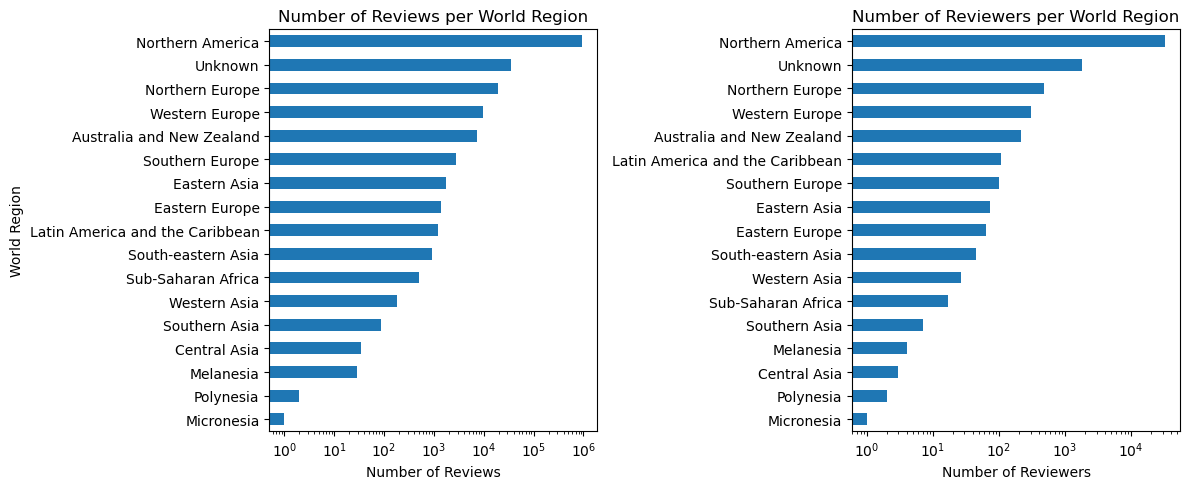

In [78]:
# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# Plot the number of reviews per world region
df.user_subregion.value_counts().sort_values().plot(kind='barh', ax=ax1)
ax1.set_xlabel('Number of Reviews')
ax1.set_ylabel('World Region')
ax1.set_title('Number of Reviews per World Region')
ax1.set_xscale('log')

# Plot the number of reviewers per world region
df.groupby('user_subregion')['user_id'].nunique().sort_values().plot(kind='barh', ax=ax2)
ax2.set_xlabel('Number of Reviewers')
ax2.set_ylabel('')  # Hide the y-label
ax2.set_title('Number of Reviewers per World Region')
ax2.set_xscale('log')

plt.tight_layout()
plt.show()

In [79]:
# add column with US state for USA users and NaN for others
df['user_US_state'] = df['user_location'].apply(lambda x: x.split(', ')[1] if 'United States' in x else np.nan)
df.sample(3)

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,beer_id_avg_appearance,beer_id_avg_aroma,beer_id_avg_palate,beer_id_avg_taste,beer_id_avg_overall,beer_id_std,beer_id_std_appearance,beer_id_std_aroma,beer_id_std_palate,beer_id_std_taste,beer_id_std_overall,serving_type_rulebased,polarity,subjectivity,readability_score,user_filtered_nbr_reviews,beer_id_filtered_nbr_reviews,beer_id_filtered_avg,beer_id_filtered_std,beer_id_filtered_avg_appearance,beer_id_filtered_avg_aroma,beer_id_filtered_avg_palate,beer_id_filtered_avg_taste,beer_id_filtered_avg_overall,beer_id_filtered_std_appearance,beer_id_filtered_std_aroma,beer_id_filtered_std_palate,beer_id_filtered_std_taste,beer_id_filtered_std_overall,user_country,user_subregion,user_US_state
665614,3951,64,American IPA,1303207200,docer.268831,3.5,3.0,4.0,3.0,3.0,3.13,Snagged a 12oz. bottle to try.. a bit spendy.....,4981,1729,3.82,7.0,827,827,1.227179e+09,"United States, Washington","United States, Delaware",378,3.924739,3.799884,3.805974,3.809600,3.841937,0.594423,0.443514,0.531692,0.520599,0.583527,0.594423,bottle,0.071176,0.458102,76.15,502,612,3.806193,0.450361,3.923203,3.788807,3.787173,3.790033,3.832108,0.426497,0.528277,0.500763,0.559685,0.580382,United States of America,Northern America,Washington
18992,8326,296,English Pale Ale,1219140000,charlatan.14050,3.5,3.5,3.0,4.0,4.0,3.75,My beer comes in an interestingly shaped 500ml...,113,80,3.42,4.5,537,505,1.107169e+09,Scotland,England,36,3.427215,3.348101,3.382911,3.379747,3.512658,0.754154,0.563517,0.722151,0.687381,0.697823,0.754154,bottle,0.111190,0.461667,65.25,187,44,3.456818,0.626421,3.431818,3.375000,3.397727,3.482955,3.539773,0.532009,0.755792,0.717955,0.687085,0.731245,Scotland,Northern Europe,NaN
144517,33651,1551,Maibock / Helles Bock,1314612000,tone77.332060,4.0,4.0,3.5,3.5,3.5,3.65,Poured from a brown 12 oz. bottle. Has a rich ...,331,175,3.35,7.0,3489,3489,1.242814e+09,"United States, Pennsylvania","United States, California",101,3.574286,3.260000,3.470000,3.377143,3.422857,0.683166,0.563034,0.598945,0.615438,0.666237,0.683166,bottle,0.343750,0.462500,94.15,3388,53,3.350566,0.613585,3.551887,3.287736,3.424528,3.330189,3.367925,0.645544,0.687100,0.669717,0.718528,0.739679,United States of America,Northern America,Pennsylvania


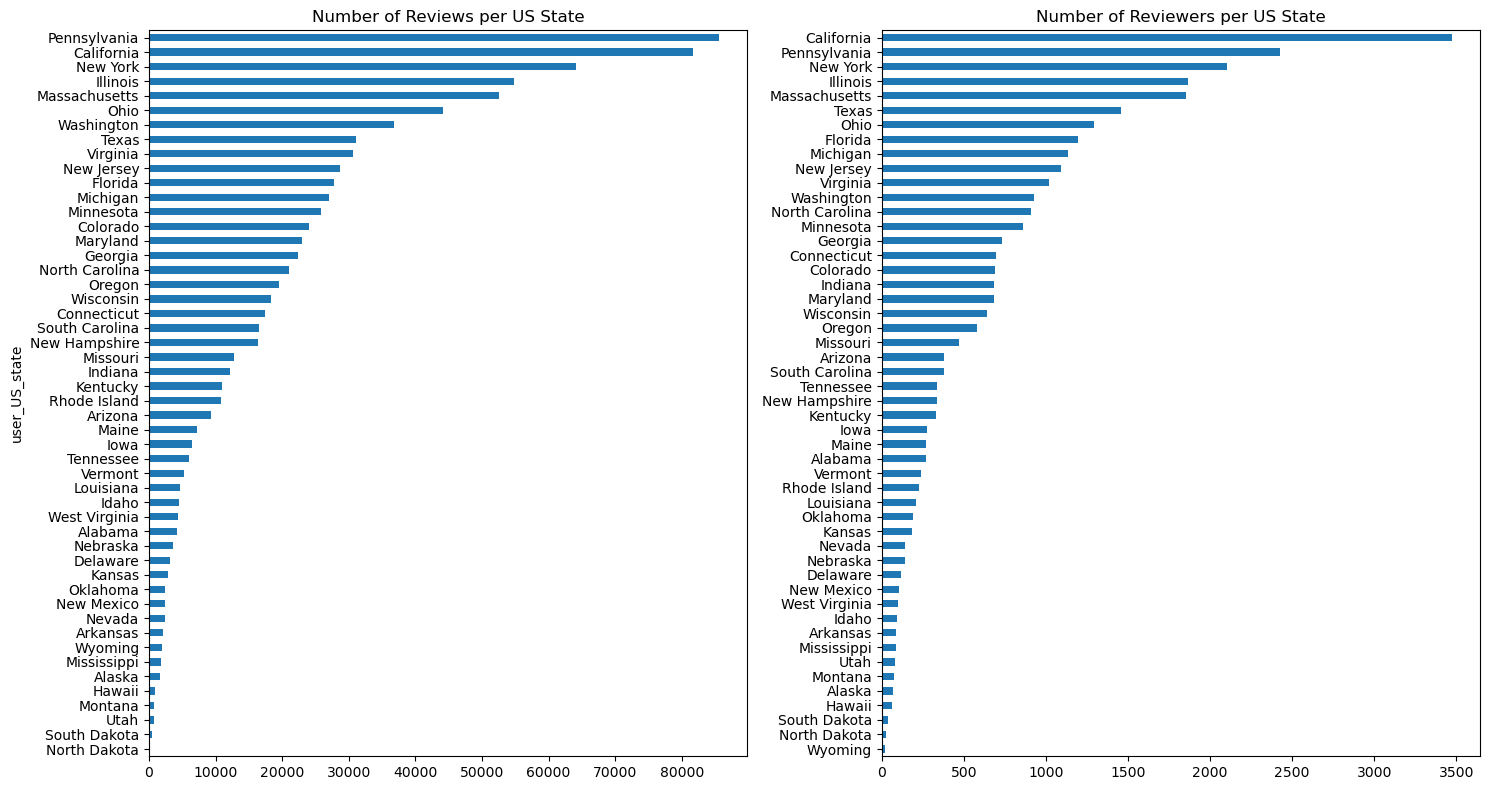

In [80]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))

# Number of reviews per US state
df.user_US_state.value_counts().sort_values().plot(kind='barh', ax=ax1)
ax1.set_title('Number of Reviews per US State')

# Number of reviewers per US state
df.groupby('user_US_state')['user_id'].nunique().sort_values().plot(kind='barh', ax=ax2)
ax2.set_title('Number of Reviewers per US State')
ax2.set_ylabel('')  # Hide the y-label

plt.tight_layout()
plt.show()

### 2.7 Beer styles grouping 🍻

In [81]:
# Group the beers by more general beer styles
beer_list = []
for beer_style in sorted(df['style'].unique()):
    print(beer_style)
    beer_list.append(beer_style)
    
    
'''location = [] 
for beer_style in sorted(df['style'].unique()):
    brewery_location = df[df['style'] == beer_style]['brewery_location'].iloc[0]
    location.append(brewery_location)
    #print(f"Beer Style: {beer_style}, Brewery Location: {brewery_location}")
print(location)'''




Altbier
American Adjunct Lager
American Amber / Red Ale
American Amber / Red Lager
American Barleywine
American Black Ale
American Blonde Ale
American Brown Ale
American Dark Wheat Ale
American Double / Imperial IPA
American Double / Imperial Pilsner
American Double / Imperial Stout
American IPA
American Malt Liquor
American Pale Ale (APA)
American Pale Lager
American Pale Wheat Ale
American Porter
American Stout
American Strong Ale
American Wild Ale
Baltic Porter
Belgian Dark Ale
Belgian IPA
Belgian Pale Ale
Belgian Strong Dark Ale
Belgian Strong Pale Ale
Berliner Weissbier
Bière de Champagne / Bière Brut
Bière de Garde
Black & Tan
Bock
Braggot
California Common / Steam Beer
Chile Beer
Cream Ale
Czech Pilsener
Doppelbock
Dortmunder / Export Lager
Dubbel
Dunkelweizen
Eisbock
English Barleywine
English Bitter
English Brown Ale
English Dark Mild Ale
English India Pale Ale (IPA)
English Pale Ale
English Pale Mild Ale
English Porter
English Stout
English Strong Ale
Euro Dark Lager
Euro Pal

'location = [] \nfor beer_style in sorted(df[\'style\'].unique()):\n    brewery_location = df[df[\'style\'] == beer_style][\'brewery_location\'].iloc[0]\n    location.append(brewery_location)\n    #print(f"Beer Style: {beer_style}, Brewery Location: {brewery_location}")\nprint(location)'

In [82]:
# Define the beer style groups
beer_groups = {
    # Ales
    'Altbier': 'Ales',
    'American Black Ale': 'Ales',
    'American Pale Ale (APA)': 'Ales',
    'American Amber / Red Ale': 'Ales',
    'American Brown Ale': 'Ales',
    'American Blonde Ale': 'Ales',
    'American IPA': 'Ales',
    'American Porter': 'Ales',
    'American Wild Ale': 'Ales',
    'Baltic Porter': 'Ales',
    'Belgian Pale Ale': 'Ales',
    'Belgian Dark Ale': 'Ales',
    'Belgian IPA': 'Ales',
    'Bière de Garde': 'Ales',
    'Cream Ale': 'Ales',
    'Dubbel': 'Ales',
    'English Bitter': 'Ales',
    'English Brown Ale': 'Ales',
    'English Dark Mild Ale': 'Ales',
    'English India Pale Ale (IPA)': 'Ales',
    'English Pale Ale': 'Ales',
    'English Pale Mild Ale': 'Ales',
    'English Porter': 'Ales',
    'Extra Special / Strong Bitter (ESB)': 'Ales',
    'Irish Red Ale': 'Ales',
    'Kölsch': 'Ales',
    'Rye Beer': 'Ales',
    'Saison / Farmhouse Ale': 'Ales',
    'Scottish Ale': 'Ales',
    'Scottish Gruit / Ancient Herbed Ale': 'Ales',

    # Stouts
    'American Double / Imperial Stout': 'Stouts',
    'American Stout': 'Stouts',
    'English Stout': 'Stouts',
    'Foreign / Export Stout': 'Stouts',
    'Irish Dry Stout': 'Stouts',
    'Milk / Sweet Stout': 'Stouts',
    'Oatmeal Stout': 'Stouts',
    'Russian Imperial Stout': 'Stouts',

    # Lagers
    'American Malt Liquor' : 'Lagers',
    'American Adjunct Lager': 'Lagers',
    'American Pale Lager': 'Lagers',
    'American Amber / Red Lager': 'Lagers',
    'California Common / Steam Beer': 'Lagers',
    'Czech Pilsener': 'Lagers',
    'Dortmunder / Export Lager': 'Lagers',
    'Euro Dark Lager': 'Lagers',
    'Euro Pale Lager': 'Lagers',
    'Euro Strong Lager': 'Lagers',
    'German Pilsener': 'Lagers',
    'Light Lager': 'Lagers',
    'Munich Dunkel Lager': 'Lagers',
    'Munich Helles Lager': 'Lagers',
    'Märzen / Oktoberfest': 'Lagers',
    'Schwarzbier': 'Lagers',
    'Vienna Lager': 'Lagers',
    
    # Strong Ales
    'American Barleywine': 'Strong Ales',
    'American Double / Imperial Pilsner': 'Strong Ales',
    'American Double / Imperial IPA': 'Strong Ales',
    'American Strong Ale': 'Strong Ales',
    'Belgian Strong Pale Ale': 'Strong Ales',
    'Belgian Strong Dark Ale': 'Strong Ales',
    'English Barleywine': 'Strong Ales',
    'English Strong Ale': 'Strong Ales',
    'Eisbock': 'Strong Ales',
    'Old Ale': 'Strong Ales',
    'Quadrupel (Quad)': 'Strong Ales',
    'Wheatwine': 'Strong Ales',
    
    # Wheat Beers
    'American Dark Wheat Ale': 'Wheat Beers',
    'American Pale Wheat Ale': 'Wheat Beers',
    'Berliner Weissbier': 'Wheat Beers',
    'Dunkelweizen': 'Wheat Beers',
    'Hefeweizen': 'Wheat Beers',
    'Kristalweizen': 'Wheat Beers',
    'Weizenbock': 'Wheat Beers',
    'Witbier': 'Wheat Beers',
    
    # Specialty and Unique Beers
    'Bière de Champagne / Bière Brut': 'Specialty and Unique Beers',
    'Black & Tan': 'Specialty and Unique Beers',
    'Chile Beer': 'Specialty and Unique Beers',
    'Fruit / Vegetable Beer': 'Specialty and Unique Beers',
    'Herbed / Spiced Beer': 'Specialty and Unique Beers',
    'Low Alcohol Beer': 'Specialty and Unique Beers',
    'Pumpkin Ale': 'Specialty and Unique Beers',
    'Rauchbier': 'Specialty and Unique Beers',
    'Roggenbier': 'Specialty and Unique Beers',
    'Sahti': 'Specialty and Unique Beers',
    'Smoked Beer': 'Specialty and Unique Beers',
    
    # Seasonal and Celebration Beers
    'Bock': 'Seasonal and Celebration Beers',
    'Doppelbock': 'Seasonal and Celebration Beers',
    'Maibock / Helles Bock': 'Seasonal and Celebration Beers',
    'Winter Warmer': 'Seasonal and Celebration Beers',
    
    # Sour Beers
    'Faro': 'Sour Beers',
    'Flanders Oud Bruin': 'Sour Beers',
    'Flanders Red Ale': 'Sour Beers',
    'Gose': 'Sour Beers',
    'Gueuze': 'Sour Beers',
    'Lambic - Fruit': 'Sour Beers',
    'Lambic - Unblended': 'Sour Beers',
    
    # Historical and Traditional Beers
    'Braggot': 'Historical and Traditional Beers',
    'Happoshu': 'Historical and Traditional Beers',
    'Kellerbier / Zwickelbier': 'Historical and Traditional Beers',
    'Kvass': 'Historical and Traditional Beers',
    'Scotch Ale / Wee Heavy': 'Historical and Traditional Beers',
    'Tripel': 'Historical and Traditional Beers',
    'Japanese Rice Lager': 'Historical and Traditional Beers',
}

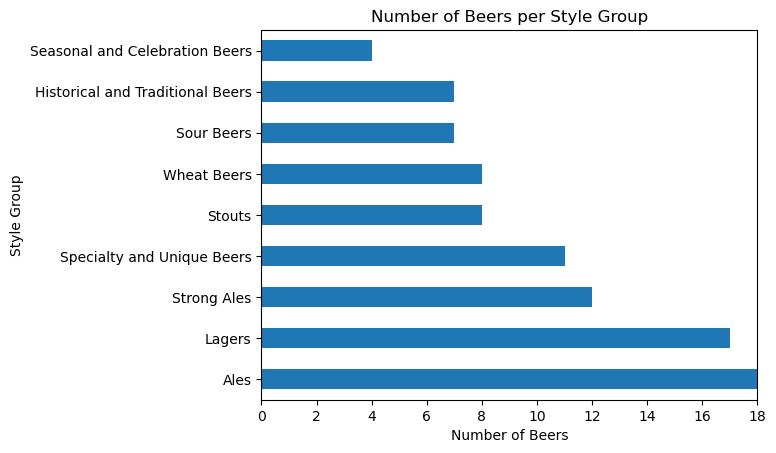

In [83]:
# Count the number of beers in each group and make a bar plot
beer_groups_df = pd.DataFrame.from_dict(beer_groups, orient='index', columns=['group'])
beer_groups_df['group'].value_counts().plot(kind='barh')
plt.title('Number of Beers per Style Group')
plt.xlim(0, 18)
plt.xlabel('Number of Beers')
plt.ylabel('Style Group')
plt.show()



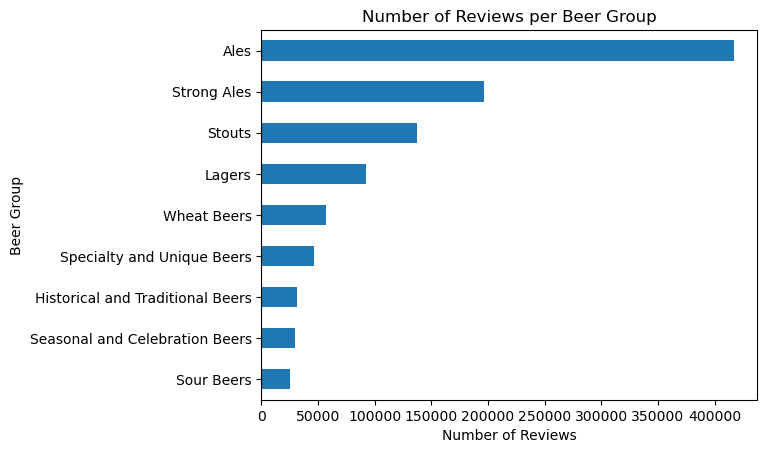

In [84]:
# Plot the number of reviews per beer group
df['beer_group'] = df['style'].map(beer_groups)
df['beer_group'].value_counts().sort_values().plot(kind='barh')
plt.xlabel('Number of Reviews')
plt.ylabel('Beer Group')
plt.title('Number of Reviews per Beer Group')
plt.show()

In [85]:
display(df.sample(3))

,beer_id,brewery_id,style,date,user_id,appearance,aroma,palate,taste,overall,rating,text,beer_nbr_ratings,beer_nbr_reviews,avg,abv,user_nbr_ratings,user_nbr_reviews,user_joined,user_location,brewery_location,brewery_nbr_beers,beer_id_avg_appearance,beer_id_avg_aroma,beer_id_avg_palate,beer_id_avg_taste,beer_id_avg_overall,beer_id_std,beer_id_std_appearance,beer_id_std_aroma,beer_id_std_palate,beer_id_std_taste,beer_id_std_overall,serving_type_rulebased,polarity,subjectivity,readability_score,user_filtered_nbr_reviews,beer_id_filtered_nbr_reviews,beer_id_filtered_avg,beer_id_filtered_std,beer_id_filtered_avg_appearance,beer_id_filtered_avg_aroma,beer_id_filtered_avg_palate,beer_id_filtered_avg_taste,beer_id_filtered_avg_overall,beer_id_filtered_std_appearance,beer_id_filtered_std_aroma,beer_id_filtered_std_palate,beer_id_filtered_std_taste,beer_id_filtered_std_overall,user_country,user_subregion,user_US_state,beer_group
361343,73457,16866,Dubbel,1327057200,sammy.3853,4.0,3.5,4.0,3.5,3.5,3.58,On tap at The Bruery Tasting Room. Dark bodied...,42,16,3.51,7.40,12046,7593,1.070276e+09,Canada,"United States, California",734,3.875000,3.593750,3.687500,3.375000,3.375000,0.288675,0.341565,0.271953,0.442531,0.341565,0.288675,draft,0.325000,0.527778,87.72,3674,9,3.453333,0.152069,3.944444,3.611111,3.833333,3.277778,3.277778,0.300463,0.333333,0.250000,0.263523,0.263523,Canada,Northern America,NaN,Ales
98269,19947,37503,American Barleywine,1215338400,mentor.2758,4.5,4.0,4.5,4.0,4.0,4.08,"Bottle shared by Crosling, thanks a million. P...",84,43,3.93,12.25,1163,1163,1.066644e+09,Unknown,Denmark,54,3.731707,4.018293,3.951220,4.030488,3.847561,0.544513,0.507415,0.341825,0.519072,0.422770,0.544513,bottle,0.221429,0.504762,73.24,595,21,3.992381,0.358983,3.869048,4.059524,4.000000,4.059524,3.809524,0.437457,0.343736,0.493710,0.394531,0.535635,Unknown,Unknown,NaN,Strong Ales
479480,21100,3818,American Double / Imperial Stout,1370858400,superspak.456300,4.0,4.0,4.0,4.5,4.5,4.30,"22 ounce bottle into snifter, bottled on 9/19/...",1364,679,4.08,11.00,5605,5603,1.273054e+09,"United States, Michigan","United States, New York",145,4.015879,4.010340,4.173191,4.154357,3.956056,0.571293,0.502055,0.443022,0.540868,0.523656,0.571293,bottle,0.169250,0.512708,62.68,5457,310,4.042258,0.394065,4.012097,3.967742,4.162097,4.125806,3.912903,0.478560,0.418726,0.513309,0.527461,0.582299,United States of America,Northern America,Michigan,Stouts


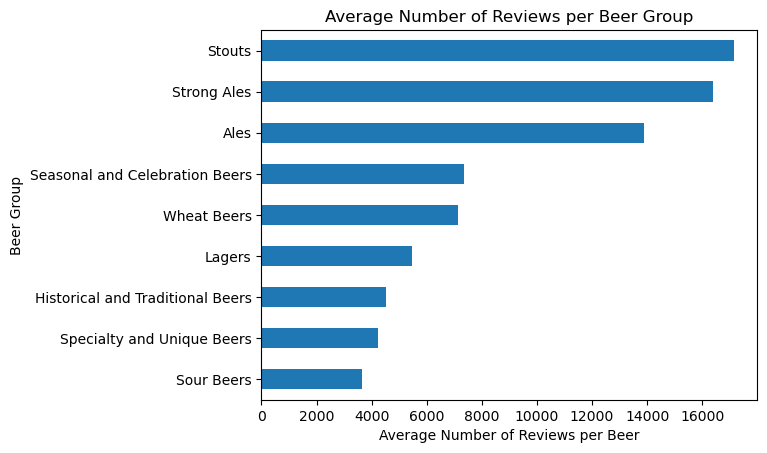

In [86]:
# Calculate the average number of reviews per beer group
average_reviews_per_group = df['beer_group'].value_counts().sort_values() / beer_groups_df['group'].value_counts()

# Plot the average number of reviews per beer group
average_reviews_per_group.sort_values().plot(kind='barh')
plt.xlabel('Average Number of Reviews per Beer')
plt.ylabel('Beer Group')
plt.title('Average Number of Reviews per Beer Group')
plt.show()


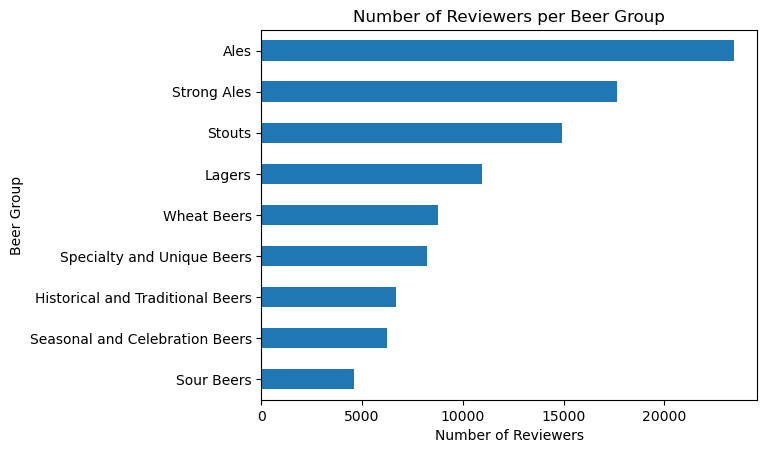

In [87]:
# Plot the number of reviewers per beer group
df.groupby('beer_group')['user_id'].nunique().sort_values().plot(kind='barh')
plt.xlabel('Number of Reviewers')
plt.ylabel('Beer Group')
plt.title('Number of Reviewers per Beer Group')
plt.show()

In [88]:
# sort the data df by serving_rulebased
sorted_data = df.sort_values('serving_type_rulebased', ascending=False)

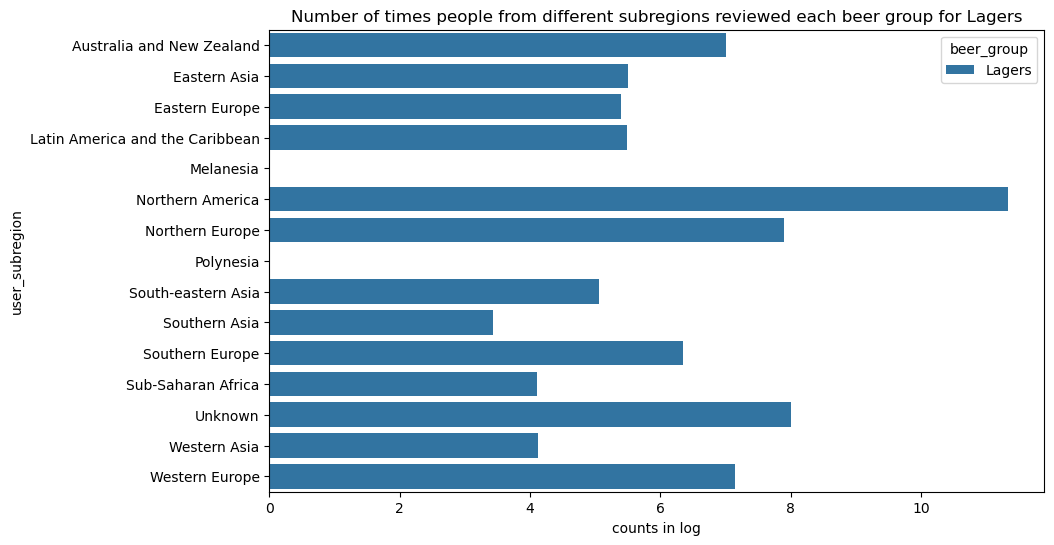

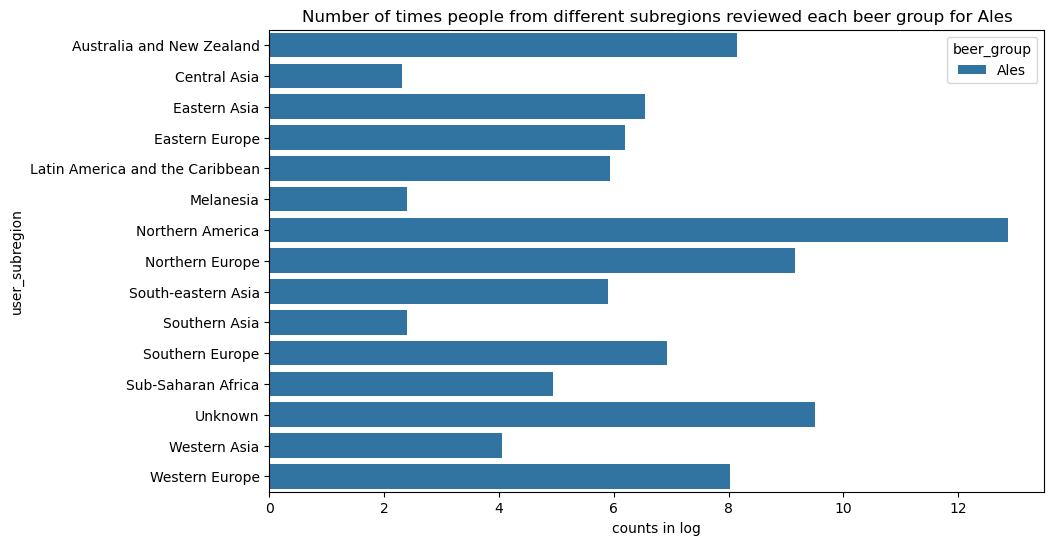

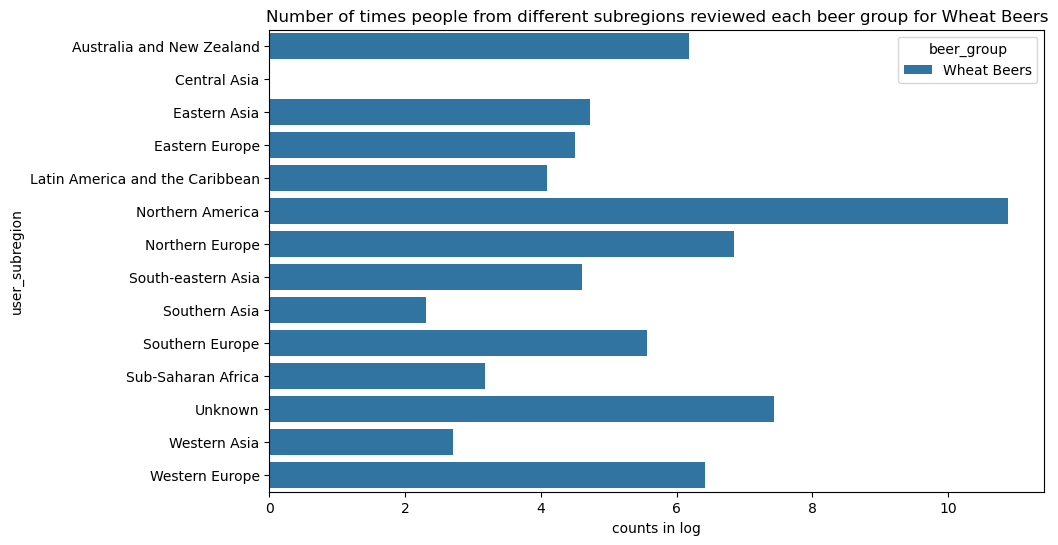

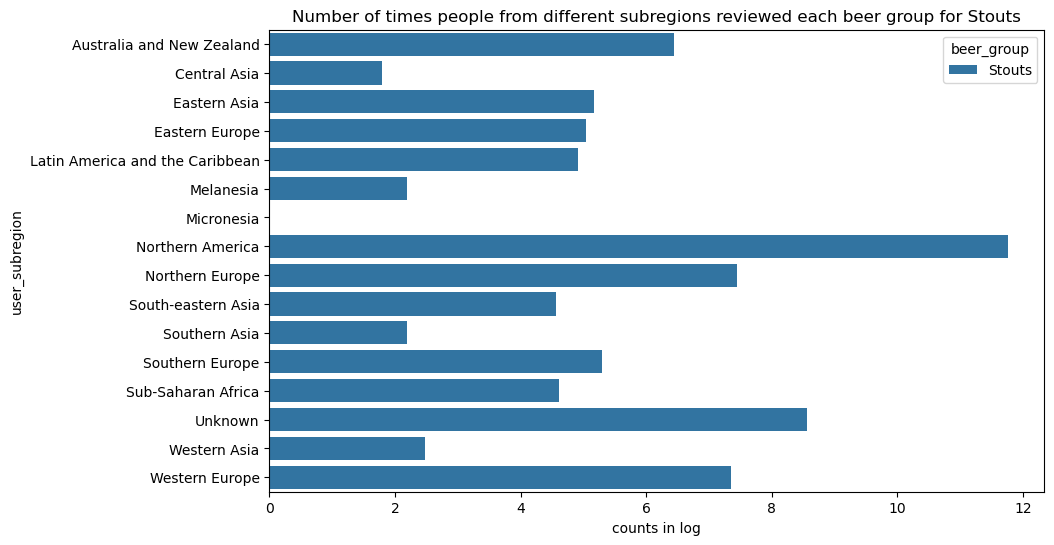

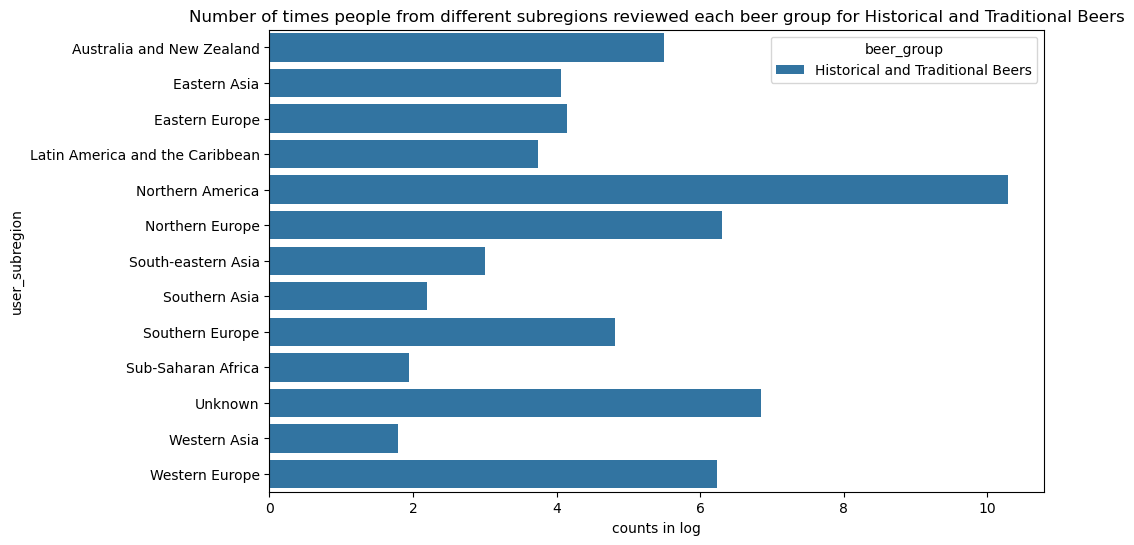

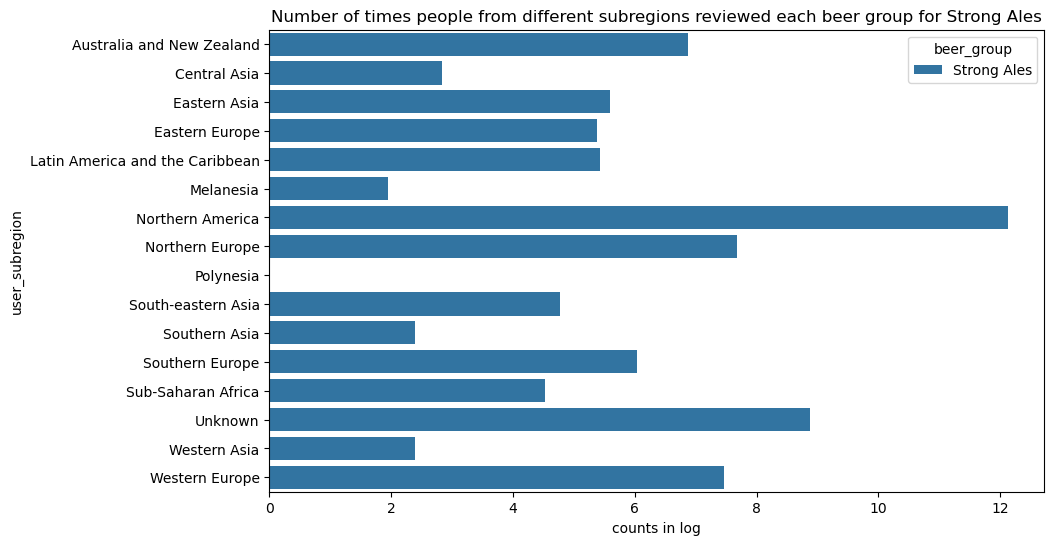

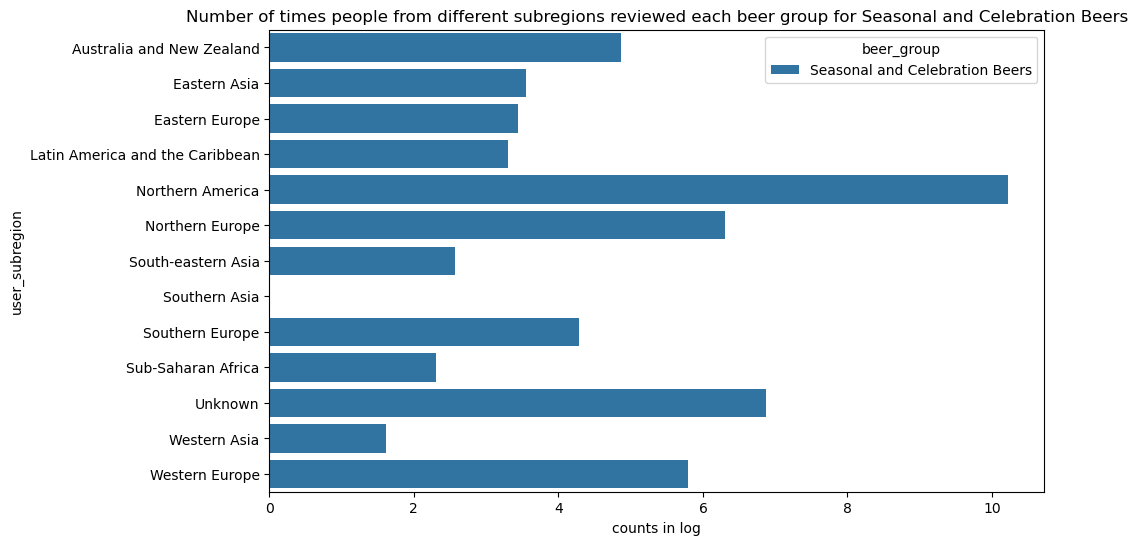

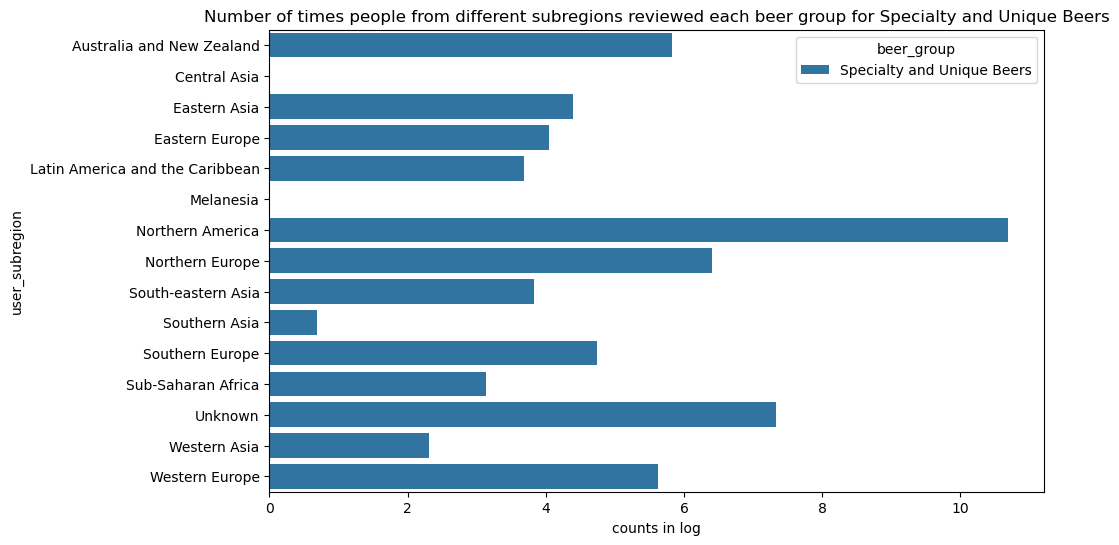

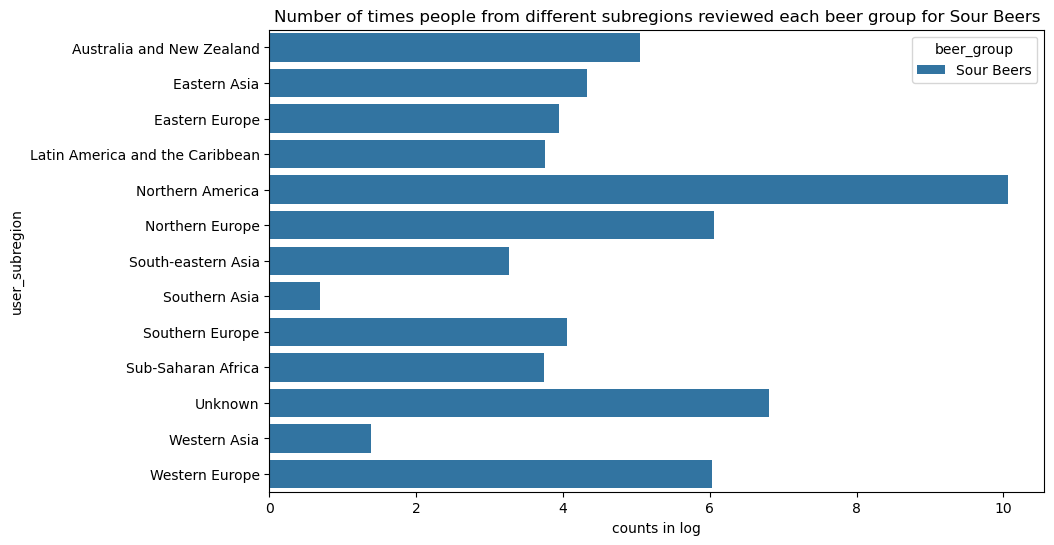

In [89]:
# Function to plot data for a given beer group
def plot_data(beer_group):
    # Filter the data for the given beer group
    grouped_data = df[df['beer_group'] == beer_group].groupby(['user_subregion', 'beer_group']).size().reset_index(name='counts')

    # Check if the grouped data is empty
    if grouped_data.empty:
        # Create a new dataframe with the desired structure, but with 0 counts
        grouped_data = pd.DataFrame({'user_subregion': df['user_subregion'].unique(),
                                     'beer_group': beer_group,
                                     'counts': 0})
    else:
        # Create a logarithmic transformation of the count data
        grouped_data['counts'] = np.log(grouped_data['counts'])

    # Create a horizontal bar chart for the selected rows
    plt.figure(figsize=(10, 6))
    sns.barplot(x='counts', y='user_subregion', hue='beer_group', data=grouped_data)
    plt.xlabel('counts in log')
    plt.title(f'Number of times people from different subregions reviewed each beer group for {beer_group}')
    plt.show()

# Loop through each beer group and plot the data
for beer_group in df['beer_group'].unique():
    try:
        plot_data(beer_group)
    except ValueError:
        print(f"No data for {beer_group}. Skipping.")

## 3. Check representation of dataset

In [91]:
# load the filtered dataset
filtered_df = df.copy(deep=True)
# filter per beer id and keep only the columns witg reviews, avg, std, or the words appearance, aroma, palate, taste, overall at the end
#list of columns to keep
columns_beer = [
    'serving_type_rulebased',
    'beer_nbr_reviews',
    'beer_id_filtered_nbr_reviews',
    'avg',
    'beer_id_avg_appearance',
    'beer_id_avg_aroma',
    'beer_id_avg_palate',
    'beer_id_avg_taste',
    'beer_id_avg_overall',
    'beer_id_std',
    'beer_id_std_appearance',
    'beer_id_std_aroma',
    'beer_id_std_palate',
    'beer_id_std_taste',
    'beer_id_std_overall',
    'beer_id_filtered_nbr_reviews',
    'beer_id_filtered_avg',
    'beer_id_filtered_std',
    'beer_id_filtered_avg_appearance',
    'beer_id_filtered_avg_aroma',
    'beer_id_filtered_avg_palate',
    'beer_id_filtered_avg_taste',
    'beer_id_filtered_avg_overall',
    'beer_id_filtered_std_appearance',
    'beer_id_filtered_std_aroma',
    'beer_id_filtered_std_palate',
    'beer_id_filtered_std_taste',
    'beer_id_filtered_std_overall'
]

columns_user = [
    'user_nbr_reviews',
    'user_filtered_nbr_reviews'
]

columns_user = ['user_nbr_reviews', 'user_filtered_nbr_reviews']

# Group by beer_id and user_id and perform aggregation
filtered_df_beer = filtered_df.groupby('beer_id').agg({col: 'first' for col in columns_beer})
filtered_df_user = filtered_df.groupby('user_id').agg({col: 'first' for col in columns_user})

In [92]:
display(filtered_df_beer)

,serving_type_rulebased,beer_nbr_reviews,beer_id_filtered_nbr_reviews,avg,beer_id_avg_appearance,beer_id_avg_aroma,beer_id_avg_palate,beer_id_avg_taste,beer_id_avg_overall,beer_id_std,beer_id_std_appearance,beer_id_std_aroma,beer_id_std_palate,beer_id_std_taste,beer_id_std_overall,beer_id_filtered_avg,beer_id_filtered_std,beer_id_filtered_avg_appearance,beer_id_filtered_avg_aroma,beer_id_filtered_avg_palate,beer_id_filtered_avg_taste,beer_id_filtered_avg_overall,beer_id_filtered_std_appearance,beer_id_filtered_std_aroma,beer_id_filtered_std_palate,beer_id_filtered_std_taste,beer_id_filtered_std_overall
beer_id,,,,,,,,,,,,,,,,,,,,,,,,,,,
4,bottle,10,6,3.64,3.950000,3.800000,3.700000,3.450000,3.700000,0.674949,0.643342,0.586894,0.752773,0.831665,0.674949,3.530000,0.540629,3.666667,3.583333,3.833333,3.333333,3.666667,0.605530,0.584523,0.258199,0.752773,0.516398
5,bottle,543,152,3.40,3.524674,3.239758,3.342644,3.379423,3.525605,0.629218,0.551432,0.589188,0.624931,0.626498,0.629218,3.358816,0.524479,3.532895,3.236842,3.304276,3.345395,3.504934,0.569422,0.615601,0.583236,0.609618,0.640435
6,bottle,1019,289,3.64,3.843287,3.537019,3.537759,3.653258,3.697187,0.585922,0.449730,0.542863,0.550551,0.538438,0.585922,3.583910,0.465059,3.839100,3.452422,3.499135,3.622837,3.628028,0.449800,0.548936,0.569592,0.584862,0.636049
7,draft,811,225,3.20,3.297188,3.212500,3.158437,3.133750,3.278125,0.774065,0.639154,0.698089,0.677024,0.727124,0.774065,3.199022,0.582486,3.288889,3.157778,3.183333,3.165556,3.294444,0.628906,0.681463,0.620070,0.687972,0.744940
8,draft,72,30,3.27,3.277778,3.055556,3.291667,3.215278,3.569444,0.857057,0.610293,0.647615,0.659439,0.701238,0.857057,3.231667,0.594898,3.266667,3.100000,3.216667,3.150000,3.550000,0.639684,0.648606,0.690868,0.684181,0.813146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293255,draft,1,1,3.83,4.000000,4.000000,3.750000,3.750000,3.750000,NaN,NaN,NaN,NaN,NaN,NaN,3.830000,NaN,4.000000,4.000000,3.750000,3.750000,3.750000,NaN,NaN,NaN,NaN,NaN
293261,draft,1,1,3.67,3.750000,3.500000,3.500000,3.750000,3.750000,NaN,NaN,NaN,NaN,NaN,NaN,3.670000,NaN,3.750000,3.500000,3.500000,3.750000,3.750000,NaN,NaN,NaN,NaN,NaN
293264,draft,1,1,4.23,4.250000,4.250000,4.000000,4.250000,4.250000,NaN,NaN,NaN,NaN,NaN,NaN,4.230000,NaN,4.250000,4.250000,4.000000,4.250000,4.250000,NaN,NaN,NaN,NaN,NaN


In [93]:
display(filtered_df_user)

,user_nbr_reviews,user_filtered_nbr_reviews
user_id,,
--dom--.709199,53,31
--weezl--.789708,3,2
-blast-tyrant-.1105240,1,1
-rick.912339,194,48
-royce-.998082,1,1
...,...,...
zythophile.1101219,184,135
zythus.301538,8,4
zz427.1113802,2,1


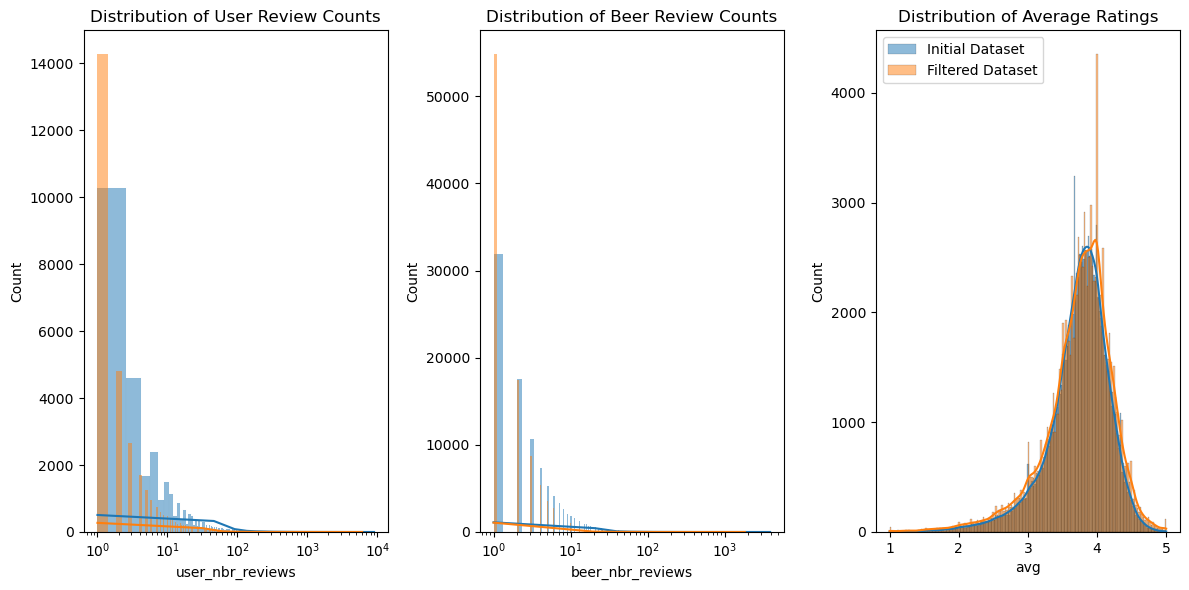

In [94]:
# Check the distribution of key columns to see if they are similar
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 6))

# Distribution of User Review Counts
axes[0].set_title('Distribution of User Review Counts')
sns.histplot(filtered_df_user['user_nbr_reviews'], kde=True, ax=axes[0], label='Initial Dataset')
sns.histplot(filtered_df_user['user_filtered_nbr_reviews'], kde=True, ax=axes[0], label='Filtered Dataset')
#axes[0].set_ylim([1e0, 25000])
axes[0].set_xscale('log')
#axes[0].set_yscale('log')

# Distribution of Beer Review Counts
axes[1].set_title('Distribution of Beer Review Counts')
sns.histplot(filtered_df_beer['beer_nbr_reviews'], kde=True, ax=axes[1], label='Initial Dataset')
sns.histplot(filtered_df_beer['beer_id_filtered_nbr_reviews'], kde=True, ax=axes[1], label='Filtered Dataset')
#axes[1].set_ylim([1e0, 2000000])
axes[1].set_xscale('log')
#axes[1].set_yscale('log')

# Distribution of Average Ratings
axes[2].set_title('Distribution of Average Ratings')
sns.histplot(filtered_df_beer['avg'], kde=True, ax=axes[2], label='Initial Dataset')
sns.histplot(filtered_df_beer['beer_id_filtered_avg'], kde=True, ax=axes[2], label='Filtered Dataset')

plt.tight_layout()
plt.legend()
plt.show()

In [96]:
# compare similar infos
t_stat, p_value = ttest_ind(filtered_df_beer['avg'], filtered_df_beer['beer_id_filtered_avg'])
print("\nT-Test Results: Average Rating")
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

filtered_df_beer_std= filtered_df_beer[filtered_df_beer['beer_id_filtered_std'].notna()]
t_stat, p_value = ttest_ind(filtered_df_beer_std['beer_id_std'], filtered_df_beer_std['beer_id_filtered_std'])
print("\nT-Test Results: Standard Deviation of Rating")
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

t_stat, p_value = ttest_ind(filtered_df_user['user_nbr_reviews'], filtered_df_user['user_filtered_nbr_reviews'])
print("\nT-Test Results: Number of user reviews ")
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

t_stat, p_value = ttest_ind(filtered_df_beer['beer_nbr_reviews'], filtered_df_beer['beer_id_filtered_nbr_reviews'])
print("\nT-Test Results: Number of beer reviews ")
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")


T-Test Results: Average Rating
T-Statistic: 0.07412149827072331, P-Value: 0.9409137752850306

T-Test Results: Standard Deviation of Rating
T-Statistic: 72.40847811266745, P-Value: 0.0

T-Test Results: Number of user reviews 
T-Statistic: 24.60913513443053, P-Value: 3.59682638256252e-133

T-Test Results: Number of beer reviews 
T-Statistic: 38.21806493032713, P-Value: 0.0


In [97]:
# compare similar infos on appearance, aroma, palate, taste and overall
t_stat, p_value = ttest_ind(filtered_df_beer['beer_id_avg_appearance'], filtered_df_beer['beer_id_filtered_avg_appearance'])
print("\nT-Test Results: Average Appearance")
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

t_stat, p_value = ttest_ind(filtered_df_beer['beer_id_avg_aroma'], filtered_df_beer['beer_id_filtered_avg_aroma'])
print("\nT-Test Results: Average Aroma")
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

t_stat, p_value = ttest_ind(filtered_df_beer['beer_id_avg_palate'], filtered_df_beer['beer_id_filtered_avg_palate'])
print("\nT-Test Results: Average Palate")
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

t_stat, p_value = ttest_ind(filtered_df_beer['beer_id_avg_taste'], filtered_df_beer['beer_id_filtered_avg_taste'])
print("\nT-Test Results: Average Taste")
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

t_stat, p_value = ttest_ind(filtered_df_beer['beer_id_avg_overall'], filtered_df_beer['beer_id_filtered_avg_overall'])
print("\nT-Test Results: Average Overall")
print(f"T-Statistic: {t_stat}, P-Value: {p_value}")



T-Test Results: Average Appearance
T-Statistic: 3.2314560632384346, P-Value: 0.0012317902373046464

T-Test Results: Average Aroma
T-Statistic: 3.4093321807240553, P-Value: 0.0006513358754662052

T-Test Results: Average Palate
T-Statistic: 2.74512390924507, P-Value: 0.006049286993041622

T-Test Results: Average Taste
T-Statistic: 3.759479868495212, P-Value: 0.00017031015063930462

T-Test Results: Average Overall
T-Statistic: 4.2962714735333485, P-Value: 1.73767858549268e-05


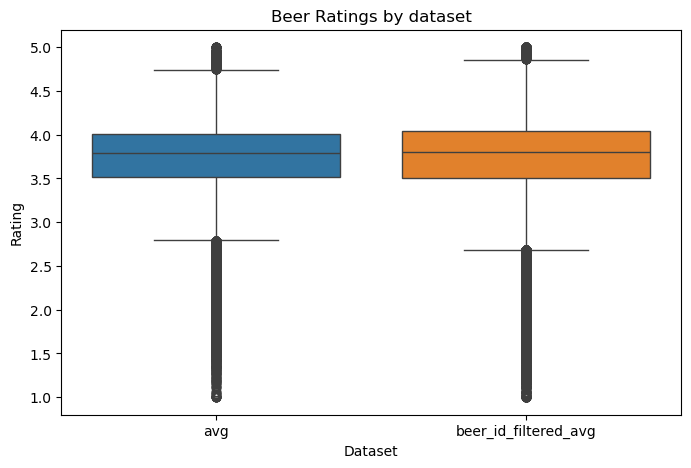

In [98]:
# box plot of the average rating per beer "avg" and the computed average rating per beer "beer_avg_computed" from df_filtered_beer
plt.figure(figsize=(8, 5))
sns.boxplot(data=filtered_df_beer[['avg', 'beer_id_filtered_avg']])
plt.title('Beer Ratings by dataset')
plt.xlabel('Dataset')
plt.ylabel('Rating')
plt.show()


<blockquote>

From these tests, we can see that the dataset is still representative of the initial one. The average rating of a beer is still the same, and the distribution of the ratings is also similar. We can therefore continue our analysis on this dataset.

However, as expected, we lost a lot of reviews, therefore the amount of reviews per beer is statistically significant from the initial amount of reviews per beer. 

We were not sure, if the same conclusion could be drawn for the amount of reviews per user, since some users might always give the serving style or never. At the end, we see that the distribution is still similar, but the amount of reviews per user is statistically significant from the initial amount of reviews per user. 

</blockquote>


## 4. Visualization 📊

> In this step, we just plotted some information, to make sure our intuition was correct. The detailed analysis will come in P3.

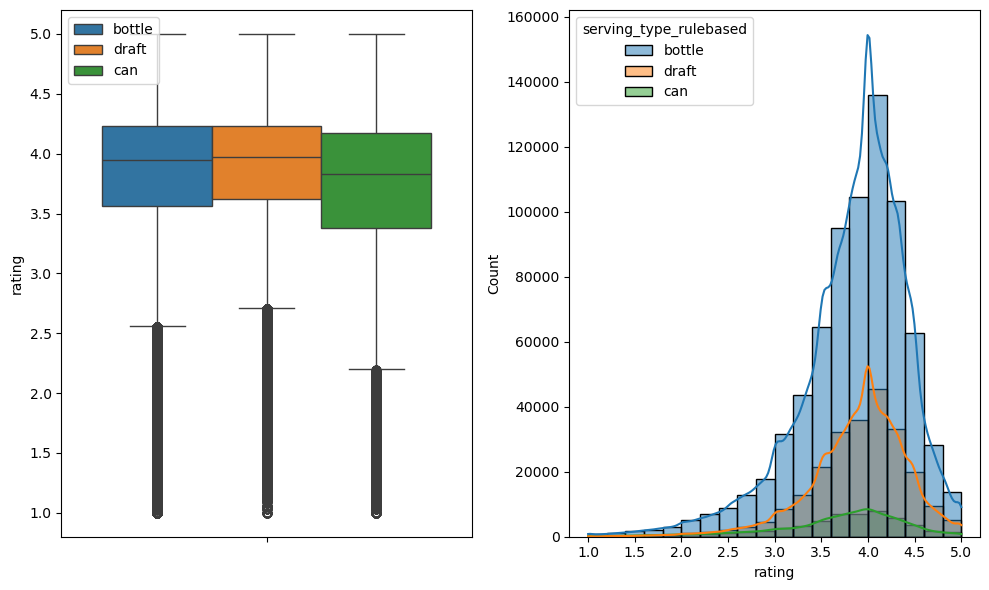

In [99]:
# show boxplot and histograms of ratings for bottle, can and draft
plt.figure(figsize=(10, 6))
plt.subplot(121)
sns.boxplot(data=df, hue='serving_type_rulebased', y='rating')
plt.legend(loc='upper left')
plt.subplot(122)
sns.histplot(data=df, hue='serving_type_rulebased', x='rating', kde=True, bins=20)
plt.tight_layout()
plt.show()

## 5. Statistical Analysis 📈

### 5.1 Measure the impact of each aspect on rating 📏
> First draft analysis to look which aspect has more impact on the rating. We will continue this analysis in P3.

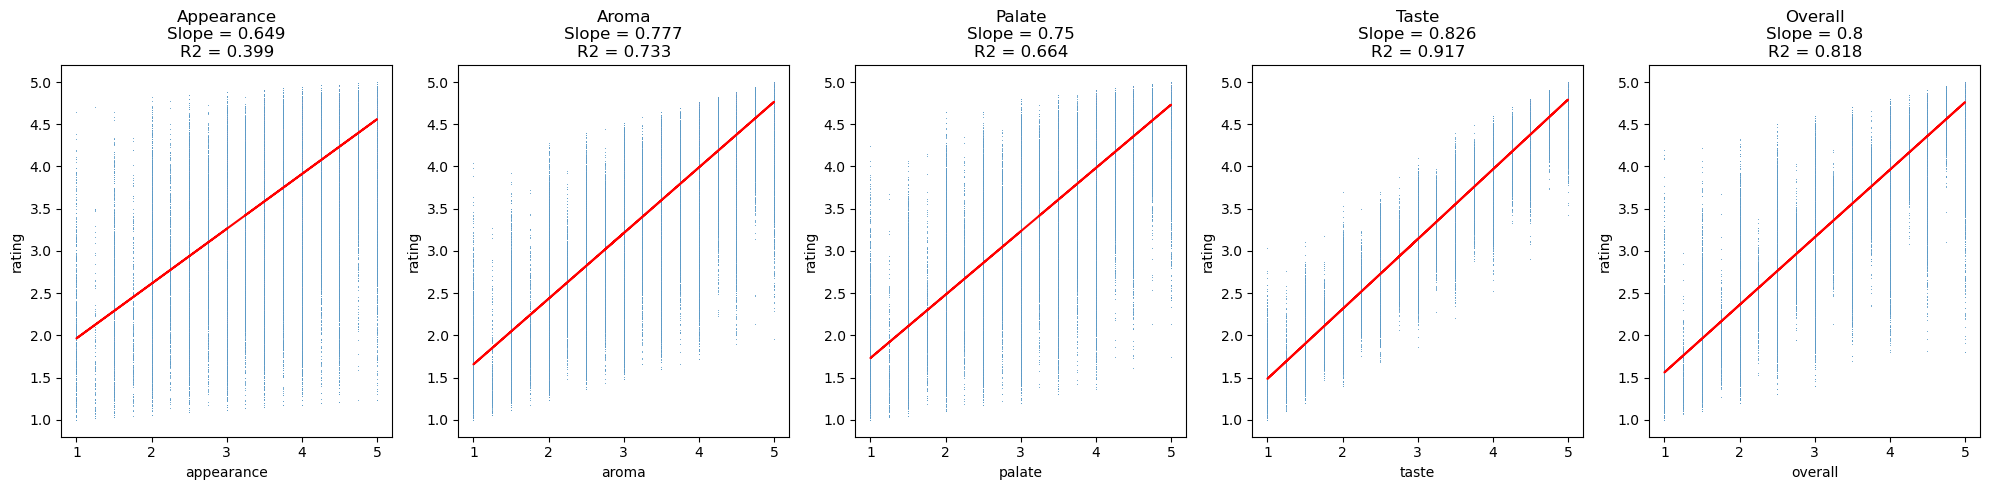

In [100]:
# fit a linear regression line to the data for all 5 aspects
reg1 = LinearRegression().fit(df[['appearance']], df['rating'])
reg2 = LinearRegression().fit(df[['aroma']], df['rating'])
reg3 = LinearRegression().fit(df[['palate']], df['rating'])
reg4 = LinearRegression().fit(df[['taste']], df['rating'])
reg5 = LinearRegression().fit(df[['overall']], df['rating'])

# create subplots for all 5 aspects
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

# plot the data and regression line for each aspect
sns.scatterplot(data=df, x='appearance', y='rating', s=0.5, ax=axs[0])
axs[0].plot(df[['appearance']], reg1.predict(df[['appearance']]), color='red')
axs[0].set_title('Appearance\nSlope = ' + str(round(reg1.coef_[0], 3)) + '\nR2 = ' + str(round(reg1.score(df[['appearance']], df['rating']), 3)))

sns.scatterplot(data=df, x='aroma', y='rating', s=0.5, ax=axs[1])
axs[1].plot(df[['aroma']], reg2.predict(df[['aroma']]), color='red')
axs[1].set_title('Aroma\nSlope = ' + str(round(reg2.coef_[0], 3)) + '\nR2 = ' + str(round(reg2.score(df[['aroma']], df['rating']), 3)))

sns.scatterplot(data=df, x='palate', y='rating', s=0.5, ax=axs[2])
axs[2].plot(df[['palate']], reg3.predict(df[['palate']]), color='red')
axs[2].set_title('Palate\nSlope = ' + str(round(reg3.coef_[0], 3)) + '\nR2 = ' + str(round(reg3.score(df[['palate']], df['rating']), 3)))

sns.scatterplot(data=df, x='taste', y='rating', s=0.5, ax=axs[3])
axs[3].plot(df[['taste']], reg4.predict(df[['taste']]), color='red')
axs[3].set_title('Taste\nSlope = ' + str(round(reg4.coef_[0], 3)) + '\nR2 = ' + str(round(reg4.score(df[['taste']], df['rating']), 3)))

sns.scatterplot(data=df, x='overall', y='rating', s=0.5, ax=axs[4])
axs[4].plot(df[['overall']], reg5.predict(df[['overall']]), color='red')
axs[4].set_title('Overall\nSlope = ' + str(round(reg5.coef_[0], 3)) + '\nR2 = ' + str(round(reg5.score(df[['overall']], df['rating']), 3)))

plt.tight_layout()
plt.show()

# should still add confidence intervals

> It seems like Taste as the biggest impact on the rating while appearance has the least impact.

### 5.2 Hypothesis testing on the new labels

In [101]:
def do_ttest(type1: str, type2: str, category: str) -> None:
    """
    Perform a t-test on the two samples of the given category for the given serving types.
    
    Parameters:
    - type1 (str): The first serving type.
    - type2 (str): The second serving type.
    - category (str): The category to perform the t-test on.

    """
    ttest = ttest_ind(df[df['serving_type_rulebased'] == type1][category],df[df['serving_type_rulebased'] == type2][category])
    if ttest[1] > 0.05:
        print('The p-value is high (' + str(ttest[1]) + '), so we cannot reject the null hypothesis that the two samples have the same average')
    else:
        print('The p-value is very low (' + str(ttest[1]) + '), so we can reject the null hypothesis that the two samples have the same average')

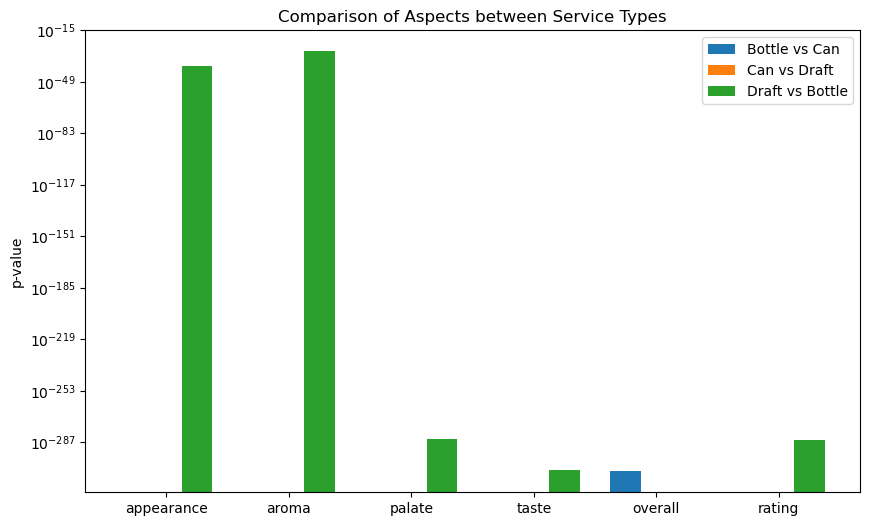

In [102]:
# compare each aspect between all three serving types

# define the columns to compare
columns = ['appearance', 'aroma', 'palate', 'taste', 'overall', 'rating']

# create an empty matrix to store the p-values
p_values = np.zeros((len(columns), 3))

# perform the t-test and store the p-values in the matrix
for i in range(len(columns)):
    ttest1 = ttest_ind(df[df['serving_type_rulebased'] == 'bottle'][columns[i]], df[df['serving_type_rulebased'] == 'can'][columns[i]])
    ttest2 = ttest_ind(df[df['serving_type_rulebased'] == 'can'][columns[i]], df[df['serving_type_rulebased'] == 'draft'][columns[i]])
    ttest3 = ttest_ind(df[df['serving_type_rulebased'] == 'draft'][columns[i]], df[df['serving_type_rulebased'] == 'bottle'][columns[i]])
    p_values[i][0] = ttest1[1]
    p_values[i][1] = ttest2[1]
    p_values[i][2] = ttest3[1]

# create the grouped bar chart
fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(columns))
width = 0.25
rects1 = ax.bar(x - width, p_values[:,0], width, label='Bottle vs Can')
rects2 = ax.bar(x, p_values[:,1], width, label='Can vs Draft')
rects3 = ax.bar(x + width, p_values[:,2], width, label='Draft vs Bottle')
ax.set_xticks(x)
ax.set_yscale('log')
ax.set_xticklabels(columns)
ax.set_ylabel('p-value')
ax.set_title('Comparison of Aspects between Service Types')
ax.legend()
plt.show()

> All the p-values are below 0.05, so we can reject the null hypothesis and conclude that there is a significant difference between the groups.

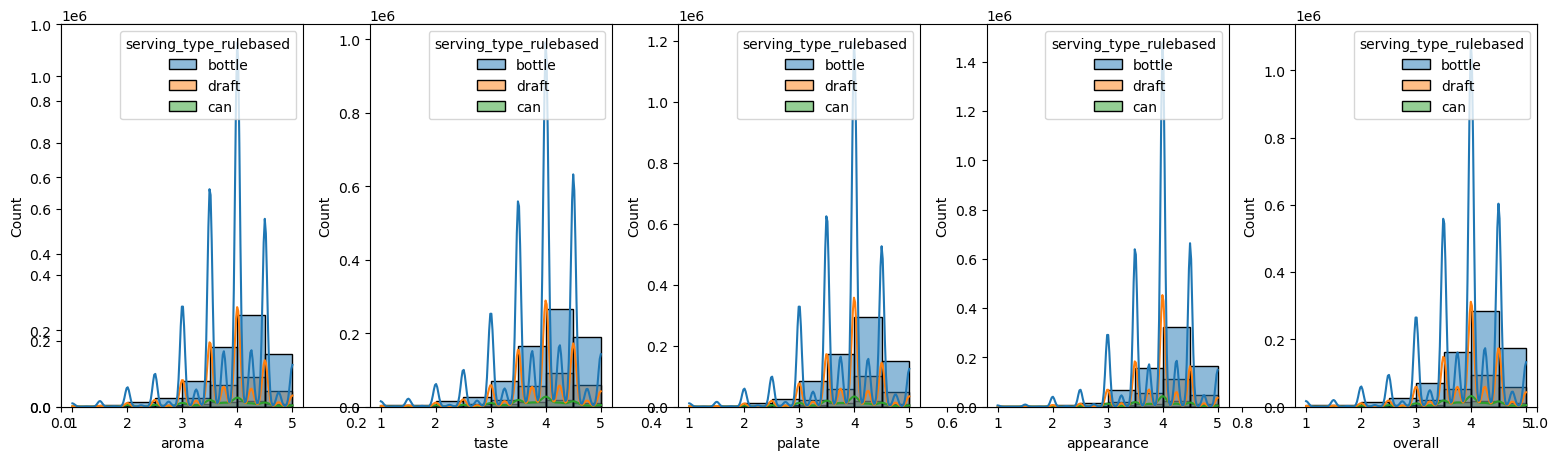

In [103]:
# Task 7.3 : analysis of the serving style on the ratings and tasting palette
# Histogram of the ratings for each serving type
plt.subplots(figsize=(16, 5))
plt.subplot(151)
sns.histplot(data=df, hue='serving_type_rulebased', x='aroma', kde=True, bins=8)
plt.subplot(152)
sns.histplot(data=df, hue='serving_type_rulebased', x='taste', kde=True, bins=8)
plt.subplot(153)
sns.histplot(data=df, hue='serving_type_rulebased', x='palate', kde=True, bins=8)
plt.subplot(154)
sns.histplot(data=df, hue='serving_type_rulebased', x='appearance', kde=True, bins=8)
plt.subplot(155)
sns.histplot(data=df, hue='serving_type_rulebased', x='overall', kde=True, bins=8)
plt.tight_layout()
plt.show()